In [25]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

In [26]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
# использую его для генерации табличек, если надо будет запустить ./optimize_data/generate_report.py
# !pip install tabulate

In [28]:
import warnings
import pickle
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

from oracle import make_oracle
from cross_entropy import test_grad
from utils import run_optimizer, plot_metric
from optimize import optimize_gd, optimize_hfn

In [29]:
with open("optimize_data/line_search_data.pkl", "rb") as log_file:
    log = pickle.load(log_file)

# Problem statement

В задании необходимо реализовать методы оптимизации для решения задачи логистической регресии: **градиентный спуск, метод ньютона, неточный метод ньютона с использованием метода сопряженных градиентов**. В качестве функции потерь используется бинарная кросс-энтропия. Даны датасет и метки классов: $X \in \mathbb{R}^{n \times m}, y \in \mathbb{R}^{n}$, нужно найти такие веса, чтобы минимизировать функцию потерь: $w^* = \underset{w \in \mathbb{R}^{m}}{\arg \min}\ F_{train}(w)$

Запишем функцию потерь в векторном виде (без суммы), а также ее градиент и гессиан, которые понадобятся нам для оптимизации. Так как это задача по оптимизации, мы считаем, что данные фиксированны, а функция - оракул от весов. В задаче мы будем использовать оракул первого и второго порядка. Обозначения могут чуть отличаться от тех, что встречаются т.к. я выводил формулы в предположении, что вектор $x_i$ - вектор строка, $y$ - вектор столбец, а веса $w$ - также вектор столбец. Так удобнее их представлять заранее, ибо в коде нам удобнее иметь их именно в таком виде для более понятной записи и вычислений.

$ F_{train}(w)= -\frac{1}{N} y^{\mathsf{T}} \log (\sigma(Xw)) + (\mathbb{1}_{n} - y^{\mathsf{T}}) \log (\mathbb{1}_{n}-\sigma(Xw)) $, where $\sigma(z) = \frac{e^{z}}{1 + e^{z}} $ 

$\nabla F_{train}(w) = \frac{1}{N} (\sigma(Xw) - y)^{\mathsf{T}}X$

$\nabla^{2} F_{train}(w) = \frac{1}{N} X^{\mathsf{T}} D_{n} X$, where $D_{n} = Diag(\sigma(Xw)(\mathbb{1}_{n} - \sigma(Xw)))$

В коде опять же удобнее вычислять $Xw$ только один раз, а далее переиспользовать, уменьшив тем самым количество обращений и к оракулу (и вычислений в целом). Для гессиана гораздо быстрее использовать поэлементное умножение т.к. создавать диагональную матрицу, а потом еще делать матричное умножение - дольше. 

## Gradient & Hessian numerical check

Для проверки градиента я реализовал методы для численного вычисления градиента и гессиана с помощью разностного-дифференцирования. В качестве меры сравниня используется максимальная относительная ошибка, которая потом усредняется по всем запускам. Датасеты генерируются согласно заданию: $𝛼𝑥+𝛽$, где $𝑥$ случайная нормальная величина с средним $0$ и дисперсией 1, $𝑦$ = 1 если $𝑎𝑥 + 𝑏 \geq 0$ и ноль иначе. Параметры $𝛼, 𝛽$ выбираются случайно из отрезка $[−1, 1]$. Чтобы датасет не был совсем тривиальным, я беру размерность признаков больше чем $1$.

In [116]:
test_grad(sample_size=1000, n_iters=1000)

Mean maximum relative error (n=1000, iterations=1000)
--------------------------------
gradient:  4.808261262001585e-11
hessian:  5.520374279351784e-05


Ошибка удовлетворительного порядка. Для гессиана она может быть больше за счет того, что численно гессиан вычисляется через значение самой функции, без использования градиента.

# A1A dataset

Результаты итоговых запусков всех методов можно увидеть в таблицах. На первый взгляд видно, что метод Ньютона сходится быстрее остальных методов на данном датасете (и на всех остальных тоже). Он также требует гораздо меньше обращений к оракулу, нежели остальные методы, в итоге сходясь к более низкой кросс-энтропии. Большинство методов поиска шага для градиентного спуска выходят по количеству итераций, а не по заданной точности. Лучше всего работает поиска шага с помощью бэктрекинга, то есть удовлетовряющего условиям Армихо. Тем не менее, это сильно зависит от начальных параметров (об этом дальше), в целом же стабильнее и точнее всего работает выбор шага с помощью метода Брента. 

Неточный метод Ньютона занимает промежуточное место, требуя гораздо больше обращений к оракулу, чем метод Ньютона, но на порядок меньше, чем требует градиентный спуск. При этом неточный метод, по моим ощущениям, гораздо более чувствителен к начальным весам и внутренним параметрам, и на некоторых стартовых точках может вырождаться в обычный градиентный спуск из-за того, что почти сразу же выходит из методы споряженных градиентов, возвращая просто антиградиент (или его неточное, но отрицательное приближение).

<table>
    <tr>
    <th style="text-align:center"> Gradient Descent </th>
    <th style="text-align:center"> Newton </th>
    <th style="text-align:center"> Hessian-Free Newton </th>
    </tr>
<tr><td>

| line search   |   entropy |   num iter |   oracle calls |   time, s |
|---------------|-----------|------------|----------------|-----------|
| golden        |  0.298463 |      10000 |         240001 |     40.99 |
| brent         |  0.298267 |       5196 |          89963 |     16.06 |
| armijo        |  0.298265 |       3897 |          31377 |      6.54 |
| wolfe         |  0.298402 |      10000 |          69433 |     16.55 |
| lipschitz     |  0.298844 |      10000 |          49999 |     10.55 |

</td><td>
    
| line search   |   entropy |   num iter |   oracle calls |   time, s |
|---------------|-----------|------------|----------------|-----------|
| golden        |  0.297875 |         11 |            265 |      0.15 |
| brent         |  0.297875 |          9 |            101 |      0.05 |
| armijo        |  0.297875 |         10 |             78 |      0.05 |
| wolfe         |  0.297876 |         11 |            178 |      0.07 |
    
</td><td>
    
| line search   |   entropy |   num iter |   oracle calls |   time, s |
|---------------|-----------|------------|----------------|-----------|
| golden        |  0.297879 |         10 |           2848 |      0.54 |
| brent         |  0.297876 |         10 |           4036 |      0.72 |
| armijo        |  0.297877 |         11 |           2865 |      0.51 |
| wolfe         |  0.297876 |         12 |           4847 |      0.86 |
    
</td></tr> 

</table>

Начнем строить графики сходимости для разных методов.

## Gradient Descent

Для градиентного спуска за наименьшее количество итераций сходится поиск шага по условиям Армихо, а наименьшую точность показывает выбор шага по схеме Нестерова, через локальную оценку константы Липшеца. Если никак не подбирать параметры у Армихо, а оставить $c = \texttt{1e-4}$ и какой-то константный начальный шаг, то лучшим методом окажется выбор шага с помощью Брента. В целом этот график повторяется на всех последующих датасетах. Общая точность тем не менее не очень большая, только около $\texttt{1e-3}$.

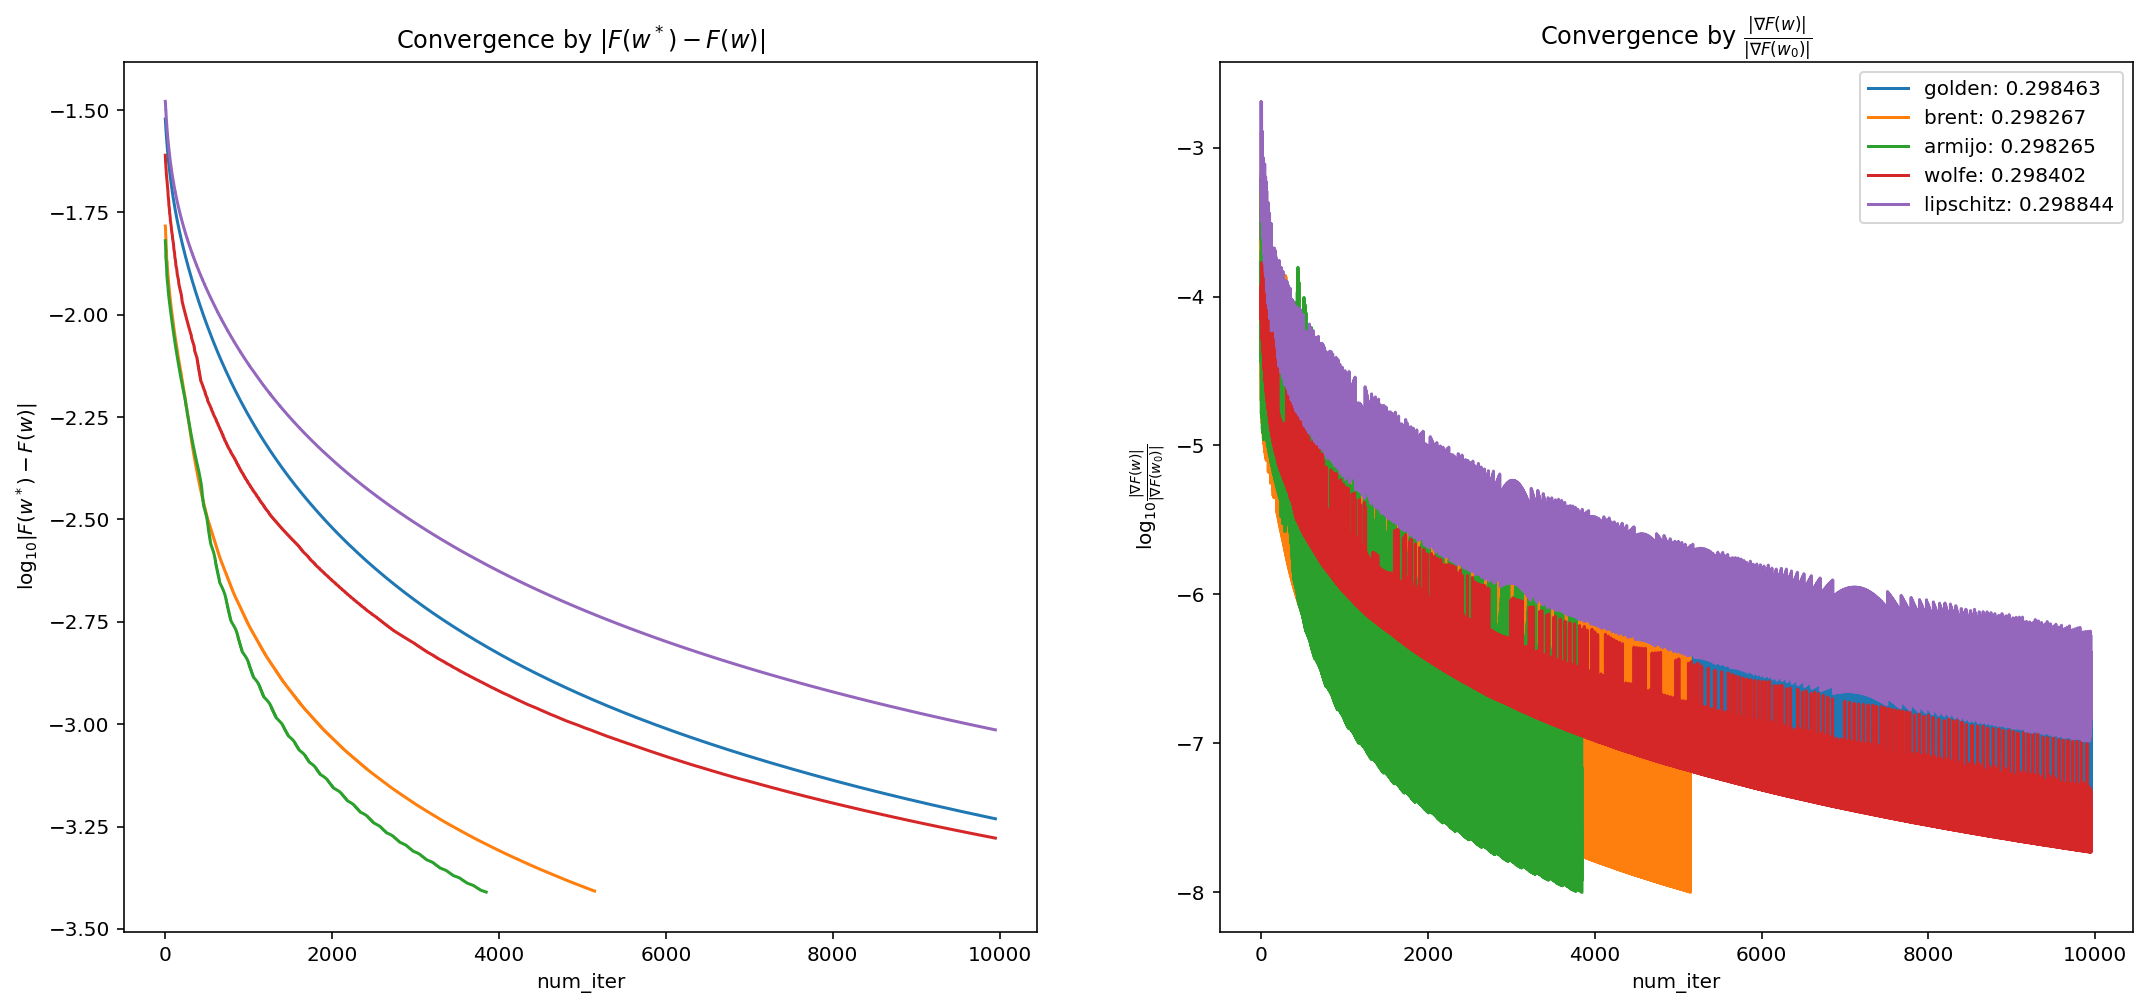

In [6]:
plot_metric(log["a1a"], "gradient descent", "num_iter", offset=50)

По количеству вызовов оракула хуже всего оказывается золотое сечение (неудивительно), а лучше всего ожидаемо Армихо. 

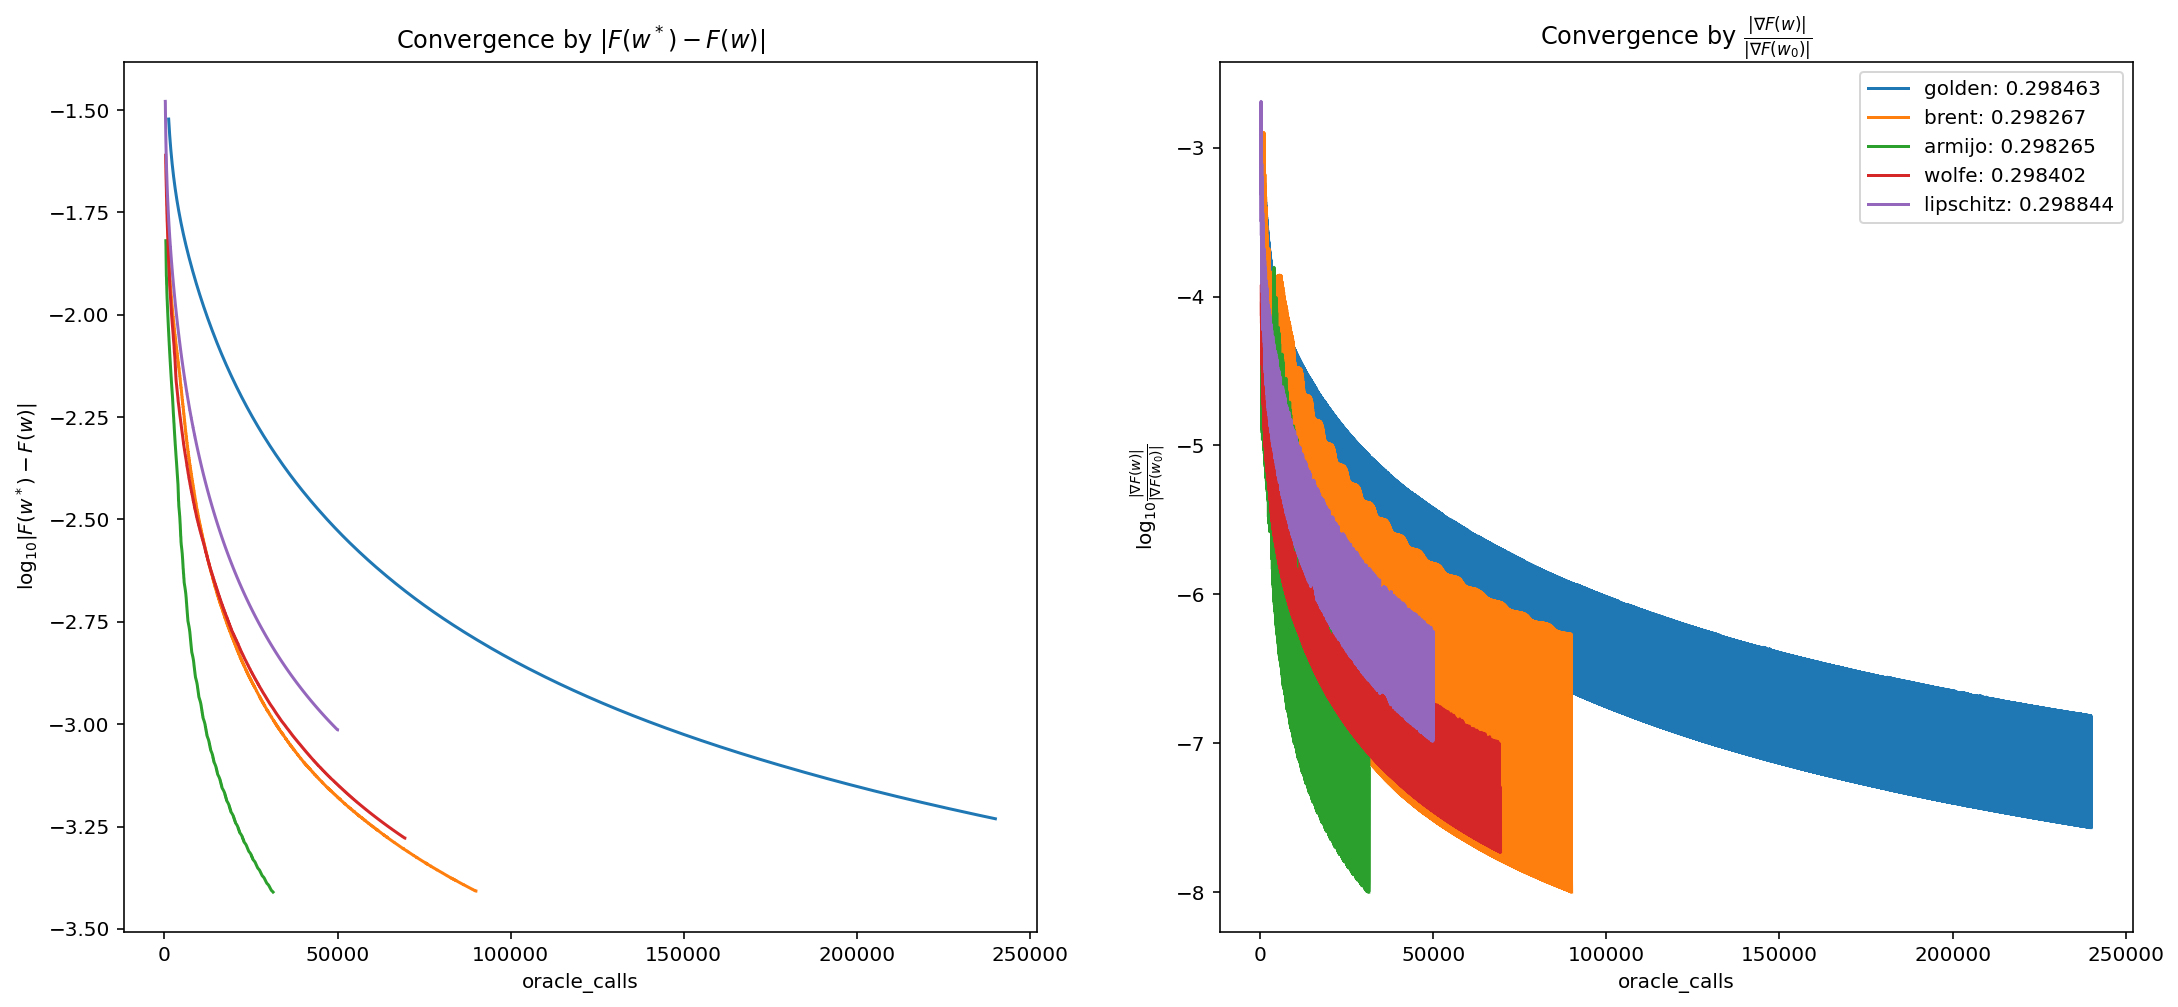

In [7]:
plot_metric(log["a1a"], "gradient descent", "oracle_calls", offset=50)

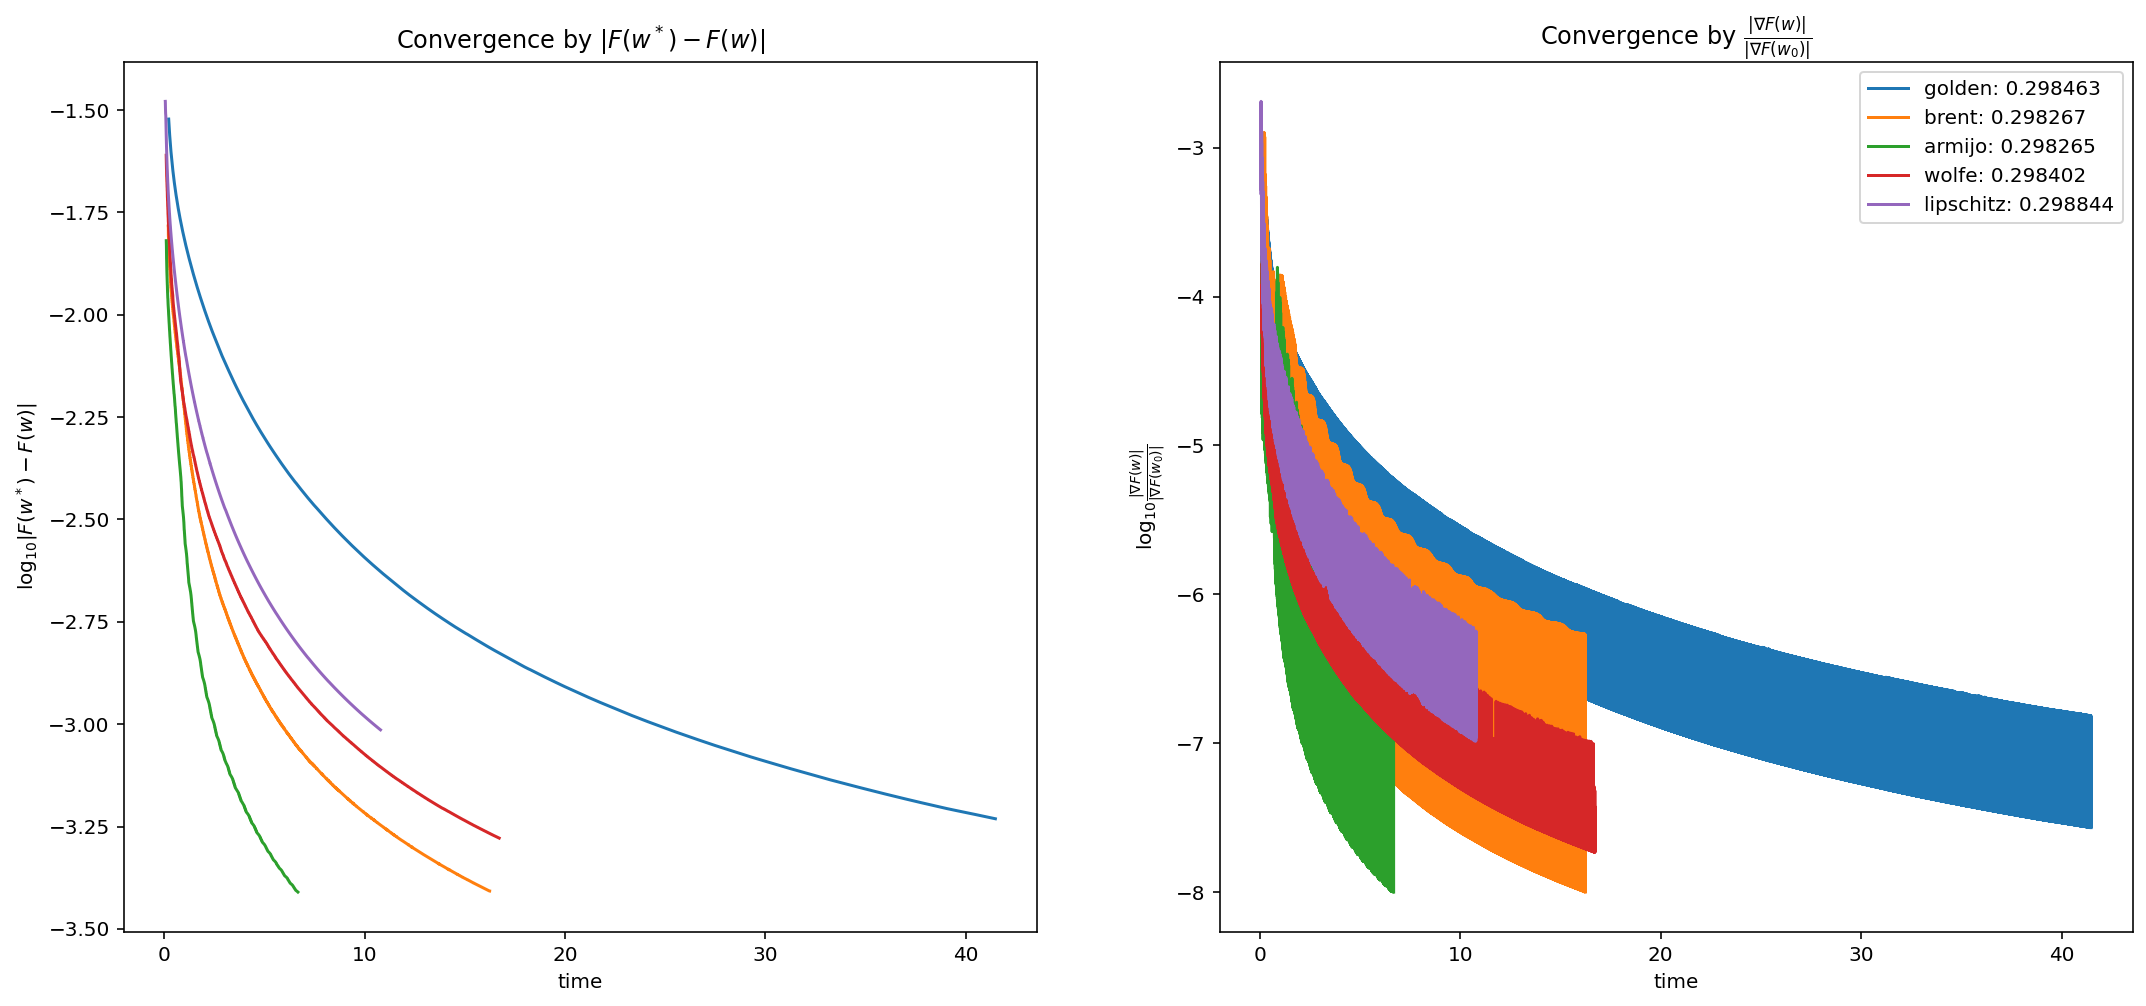

In [9]:
plot_metric(log["a1a"], "gradient descent", "time", offset=50)

В целом, все методы стартовали с нулевых начальных весов. Несмотря на то, что начальные точка не должна влиять на сходимось метода, она влияет на количество итераций до сходимости. На единичных весах сходится хуже (за исключением Армихо, там он может сойтись за 900 итераций), лучше всего на весах из равномерного стандартного распределения. Тем не менее, в отличие от последующих методов градиентный спуск в любом случае сходится из большинства начальных точек (стандартного нормального, единиц, равномерного, нулей).

### Armijo parameters

Интересно, что в моей реализации, чем меньше значение $c$, тем лучше работает градиентный спуск. В обсуждении с однокурсниками выяснилось, что у них ровно наоборот. Также, с помощью выбора начального шага для Армихо (и Вольфе) можно существенно улучшить скорость сходимости оптимизации. Например, в качестве начально шага можно делать вначале брекетинг, после чего брать максимальный по $x$ элемент. Можно взять среднее и получится результат лучше. Можно взять взвешенное среднее со значением в этой точке $x * f.x$, тогда Армихо сойдется за 2к итераций и за ~900 из единичных весов. В целом Армихо выглядит как один из лучших выборов, который не требует слишком много вызовов оракула и при этом быстро сходится.

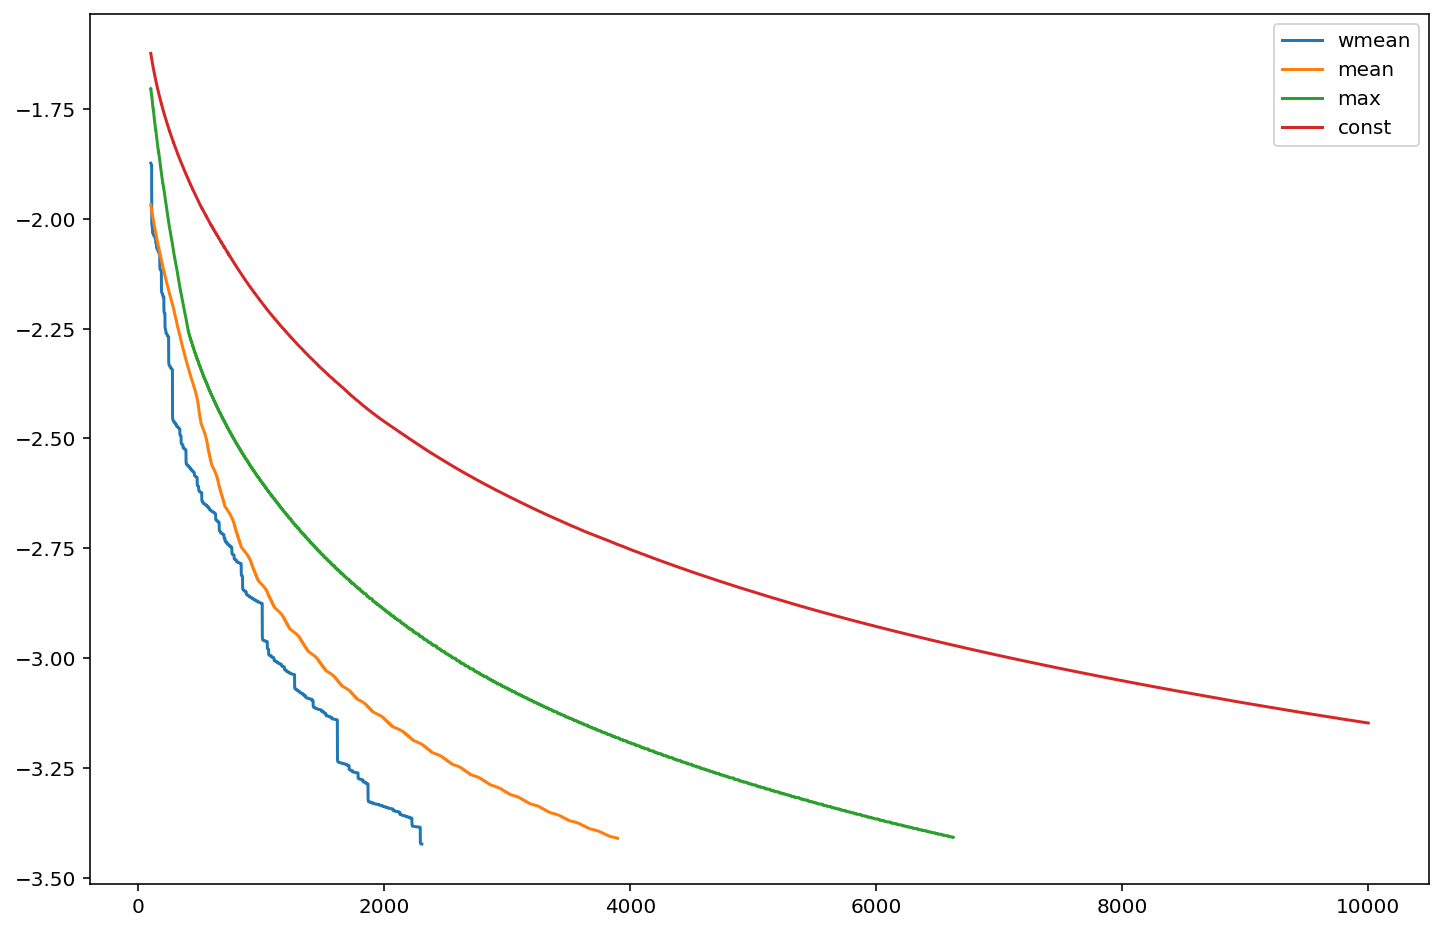

In [30]:
plt.figure(figsize=(12, 8))
for init in ["wmean", "mean", "max", "const"]:
    armijo_log = run_optimizer("data/a1a.txt", optimize_gd, line_search_method="armijo", armijo_init=init)
    info = armijo_log.get_log()
    
    plt.plot(np.arange(info["num_iter"])[100:], 
             np.log10(np.abs(info["entropy"]) - 0.2978755986559931)[100:], label=f"{init}")
plt.legend();

## Newton

Метод Ньютона сходится за гораздо меньшее количество итераций и, что интересно, на нашей задаче независимо от количества данных. То есть на сгенерированном датасете большого размера он сойдется за такое же количество итераций, просто каждая займет чуть больше времени. В области минимума шаг почти у всех методов выбора шага оказывается около единичного. Особой разницы от того как выбирать шаг нет, они все сходятся к точности $\texttt{1e-8}$.

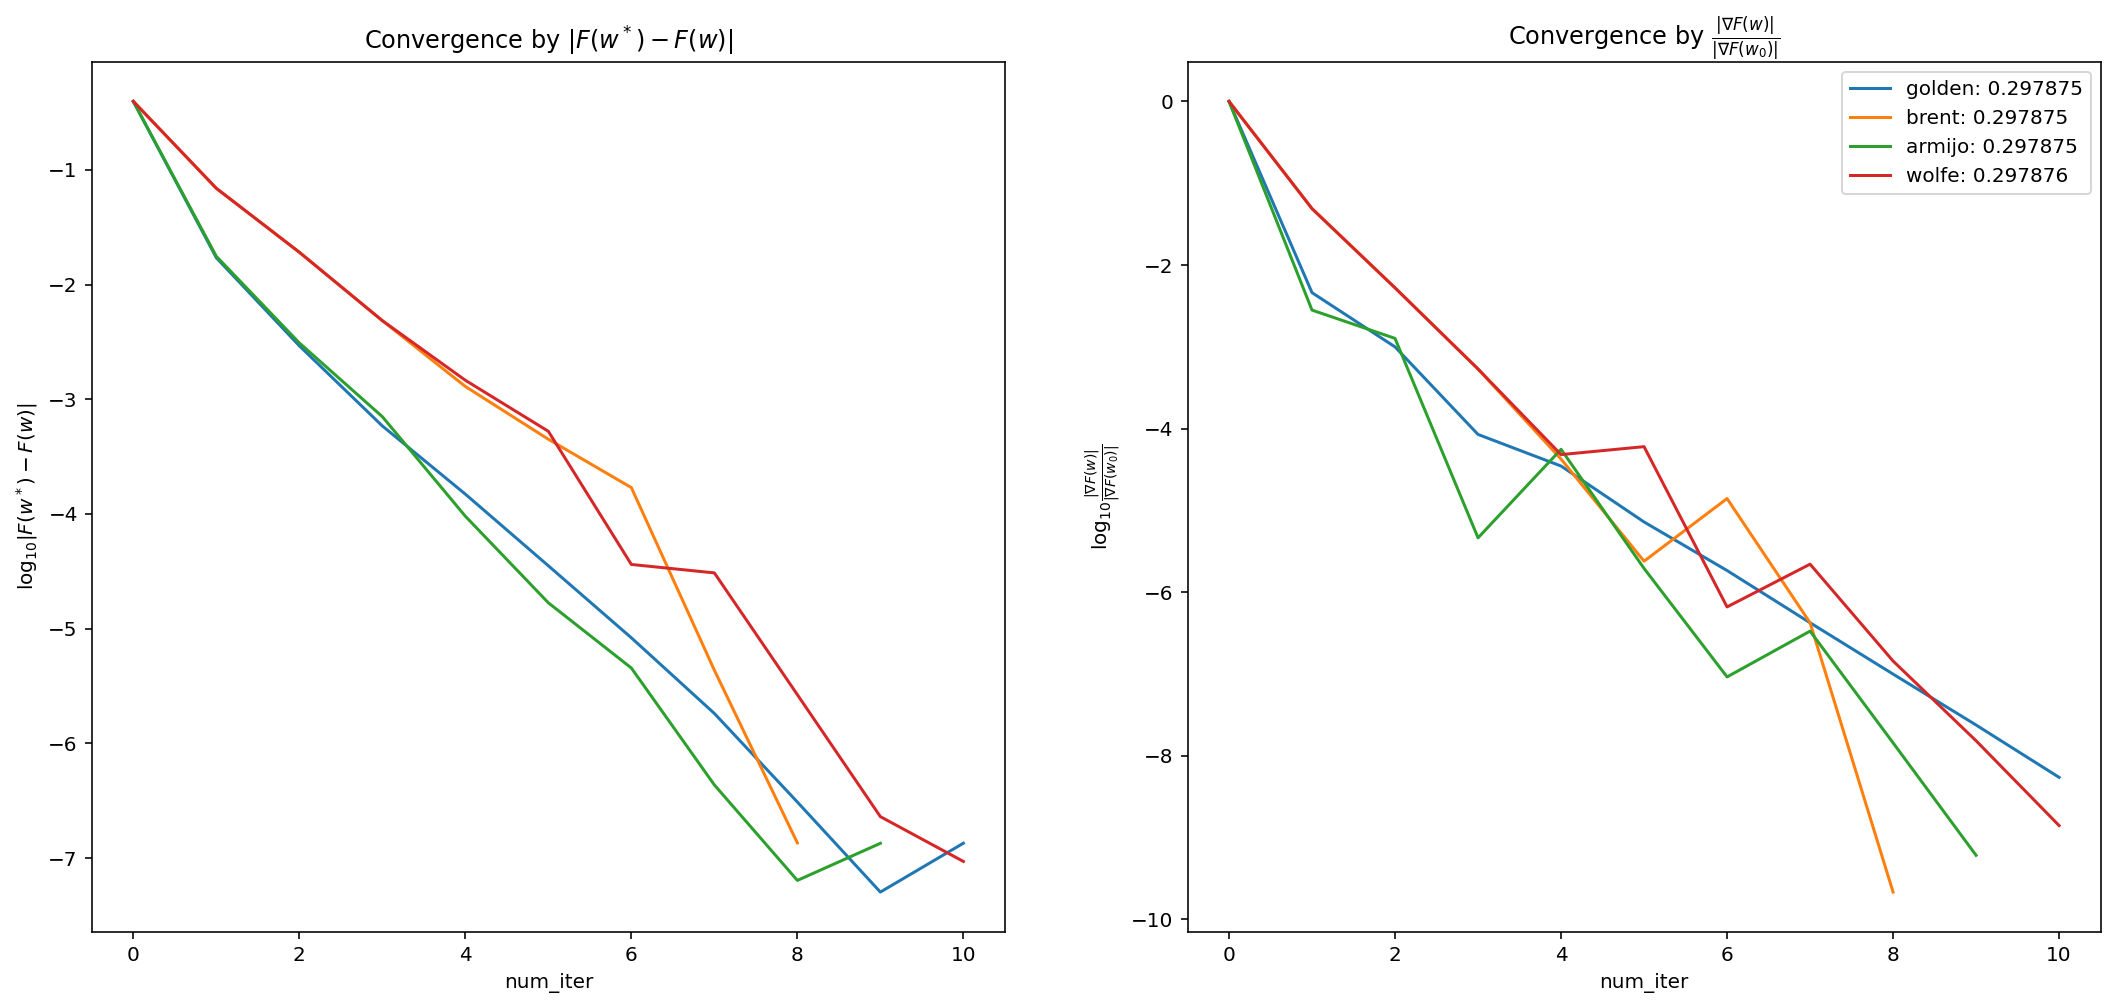

In [31]:
plot_metric(log["a1a"], "newton", "num_iter")

По количеству вызовов оракула лучшим оказывается Армихо и Брент.

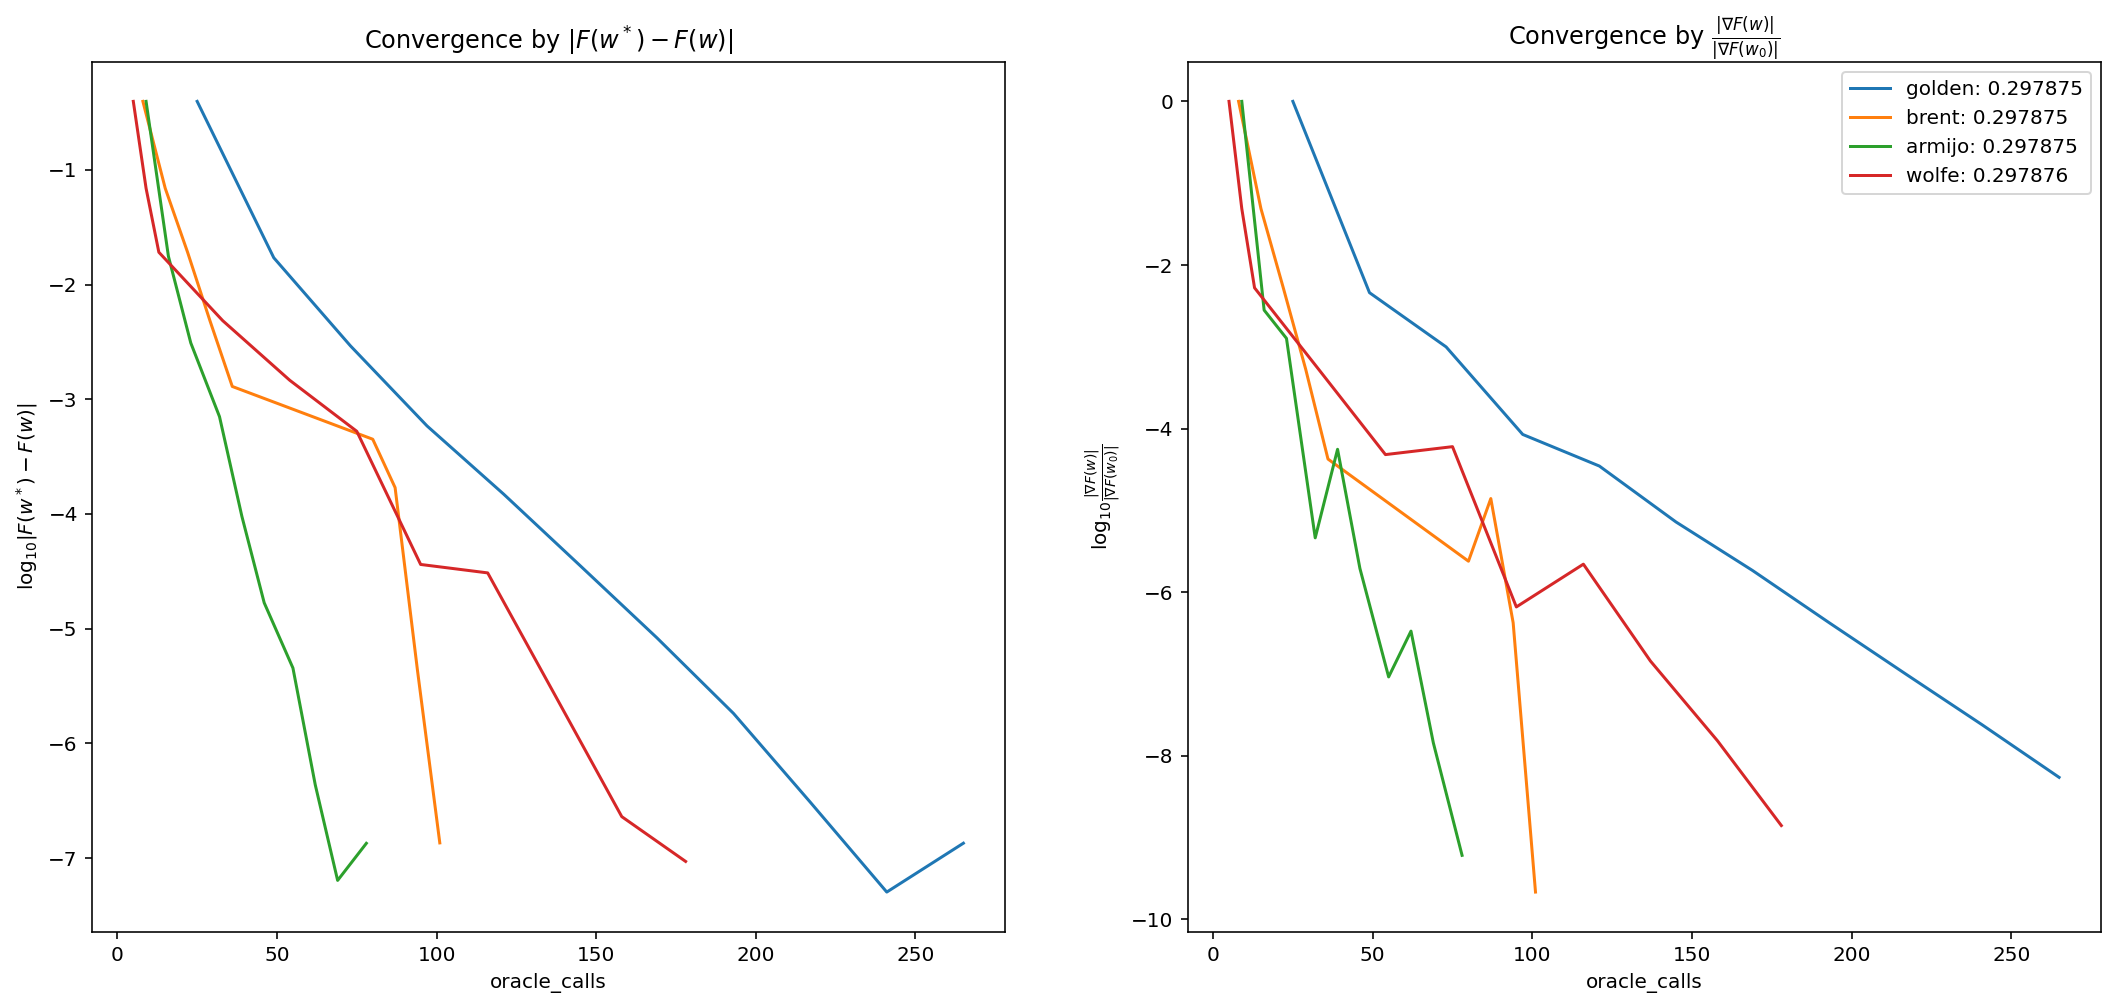

In [11]:
plot_metric(log["a1a"], "newton", "oracle_calls")

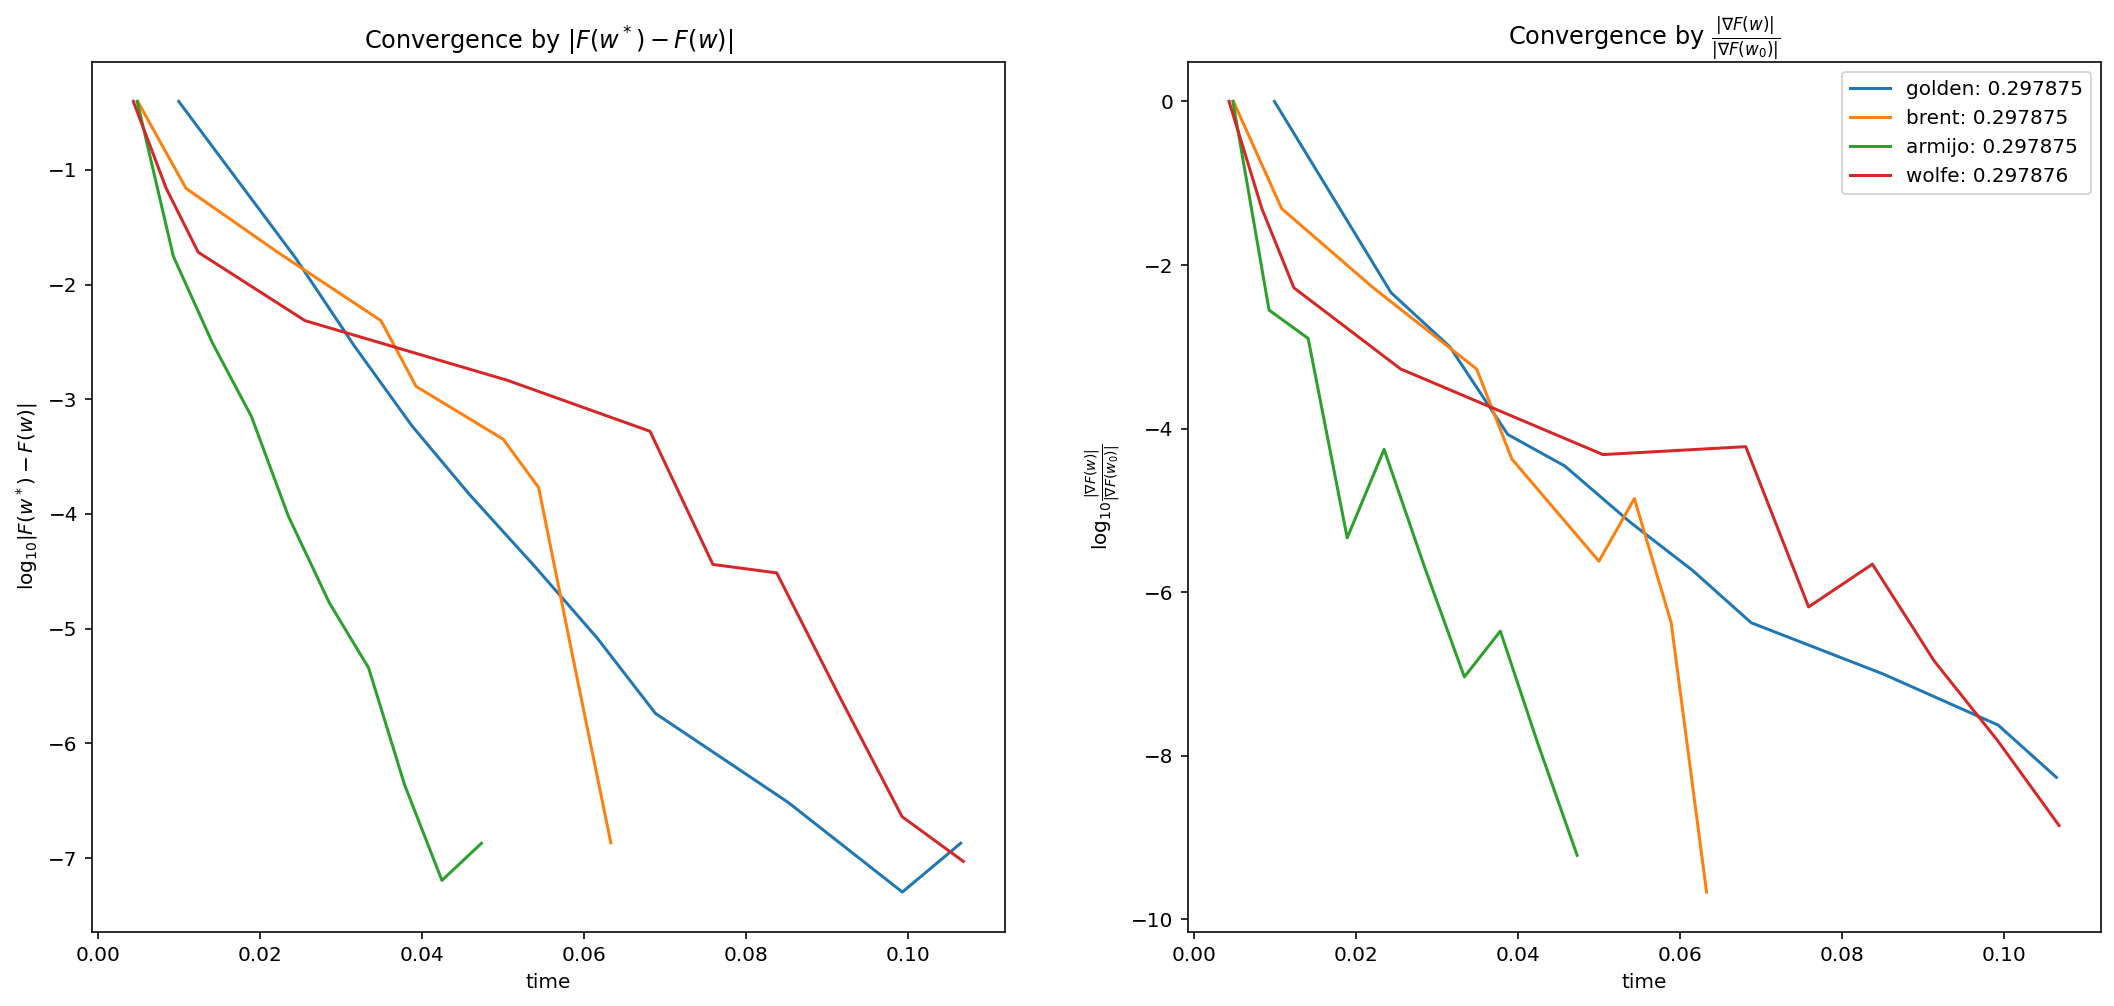

In [12]:
plot_metric(log["a1a"], "newton", "time")

Ньютон может сходится не из любой начальной точки. Он почти всегда падает (либо стоит на месте либо гессиан становится почти нулевым) на стартовых весах из единиц, равномерного. В целом, все нестабильности исправяются нормализацией шага, однако тогда метод начинается сходится за большее количество итераций ~100. Заметно, что также оказывается важна константа, с которой мы начинаем поправлять гессиан и часто большее ее начальное значение улучшает скорость сходимости, например с $\texttt{1e-16}$ до $\texttt{1e-2}$. Я не смог придумать сколько либо разумной эвристики когда стоит адаптивно нормализовывать шаг (направление), а в остальное время шагать в направлении полностью. 

## Hessian-Free Newton

В неточном методе Ньютона я не вычислял умножение гессиана на вектор явно, а выдавал значение посчитанное через центрированное конечно-разностное приближение (из формулы тейлора). Направление находится с помощью решения системы методом сопряженных градиентов. У этого метода наблюдались похожие проблемы с начальной точкой, которые также могут быть исправлены нормализацией шага (направления), но с последующим увеличением количества итераций до сходимости. В общем себя лучше всего показывает Брент, а также Армихо.

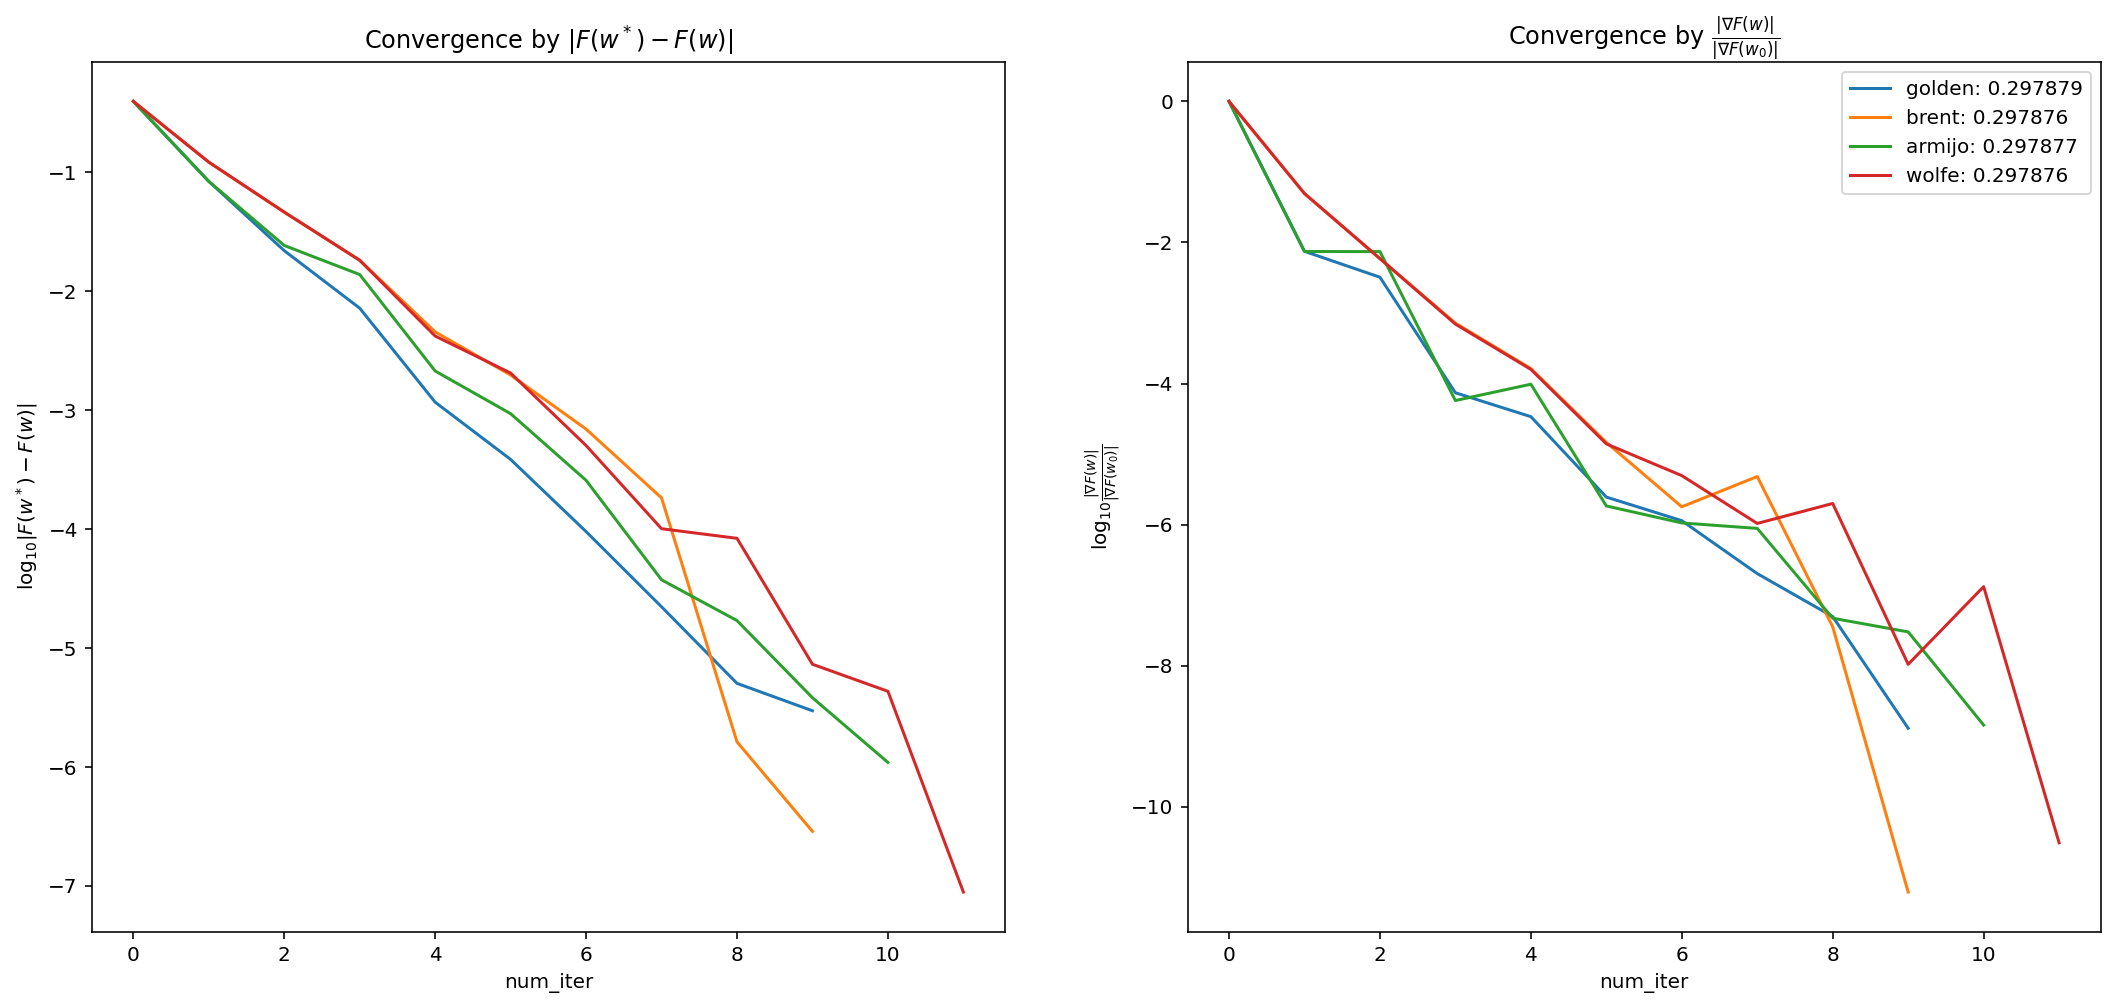

In [13]:
plot_metric(log["a1a"], "hf_newton", "num_iter")

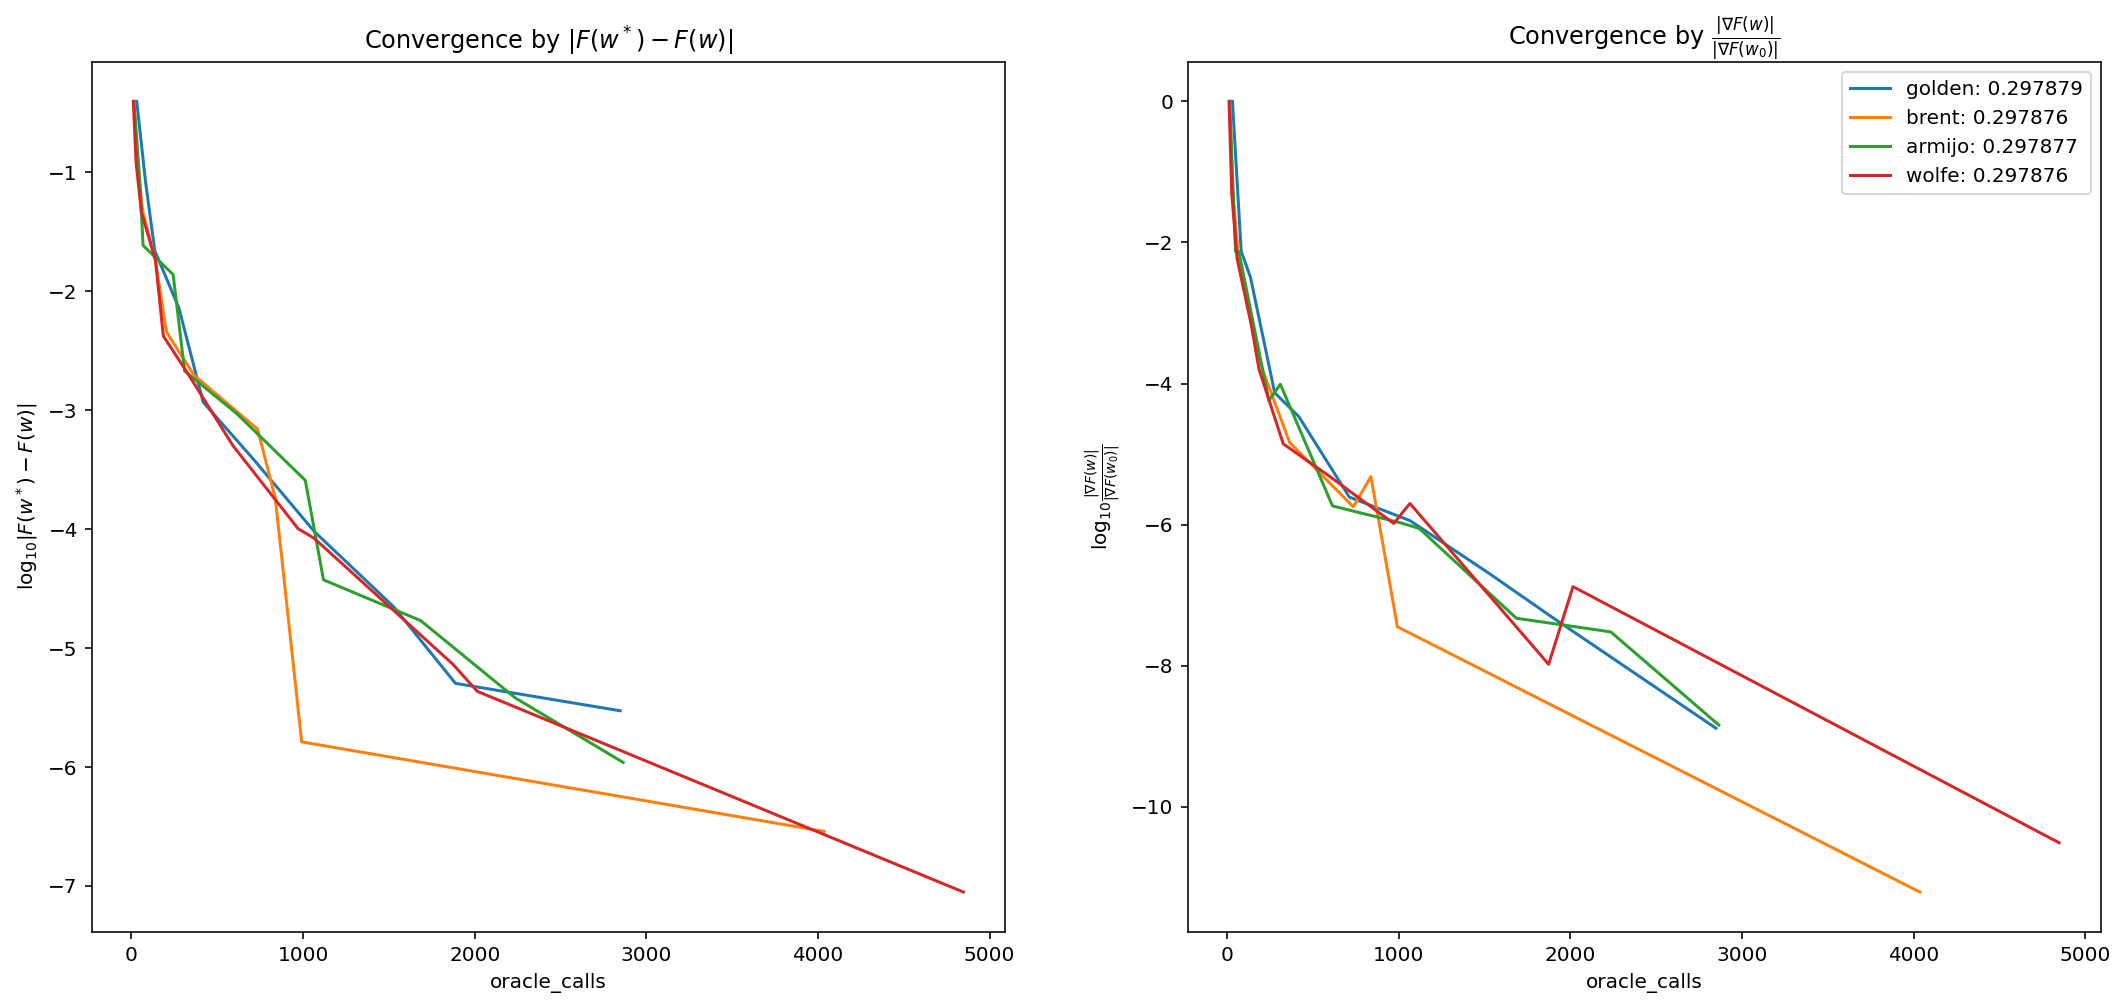

In [14]:
plot_metric(log["a1a"], "hf_newton", "oracle_calls")

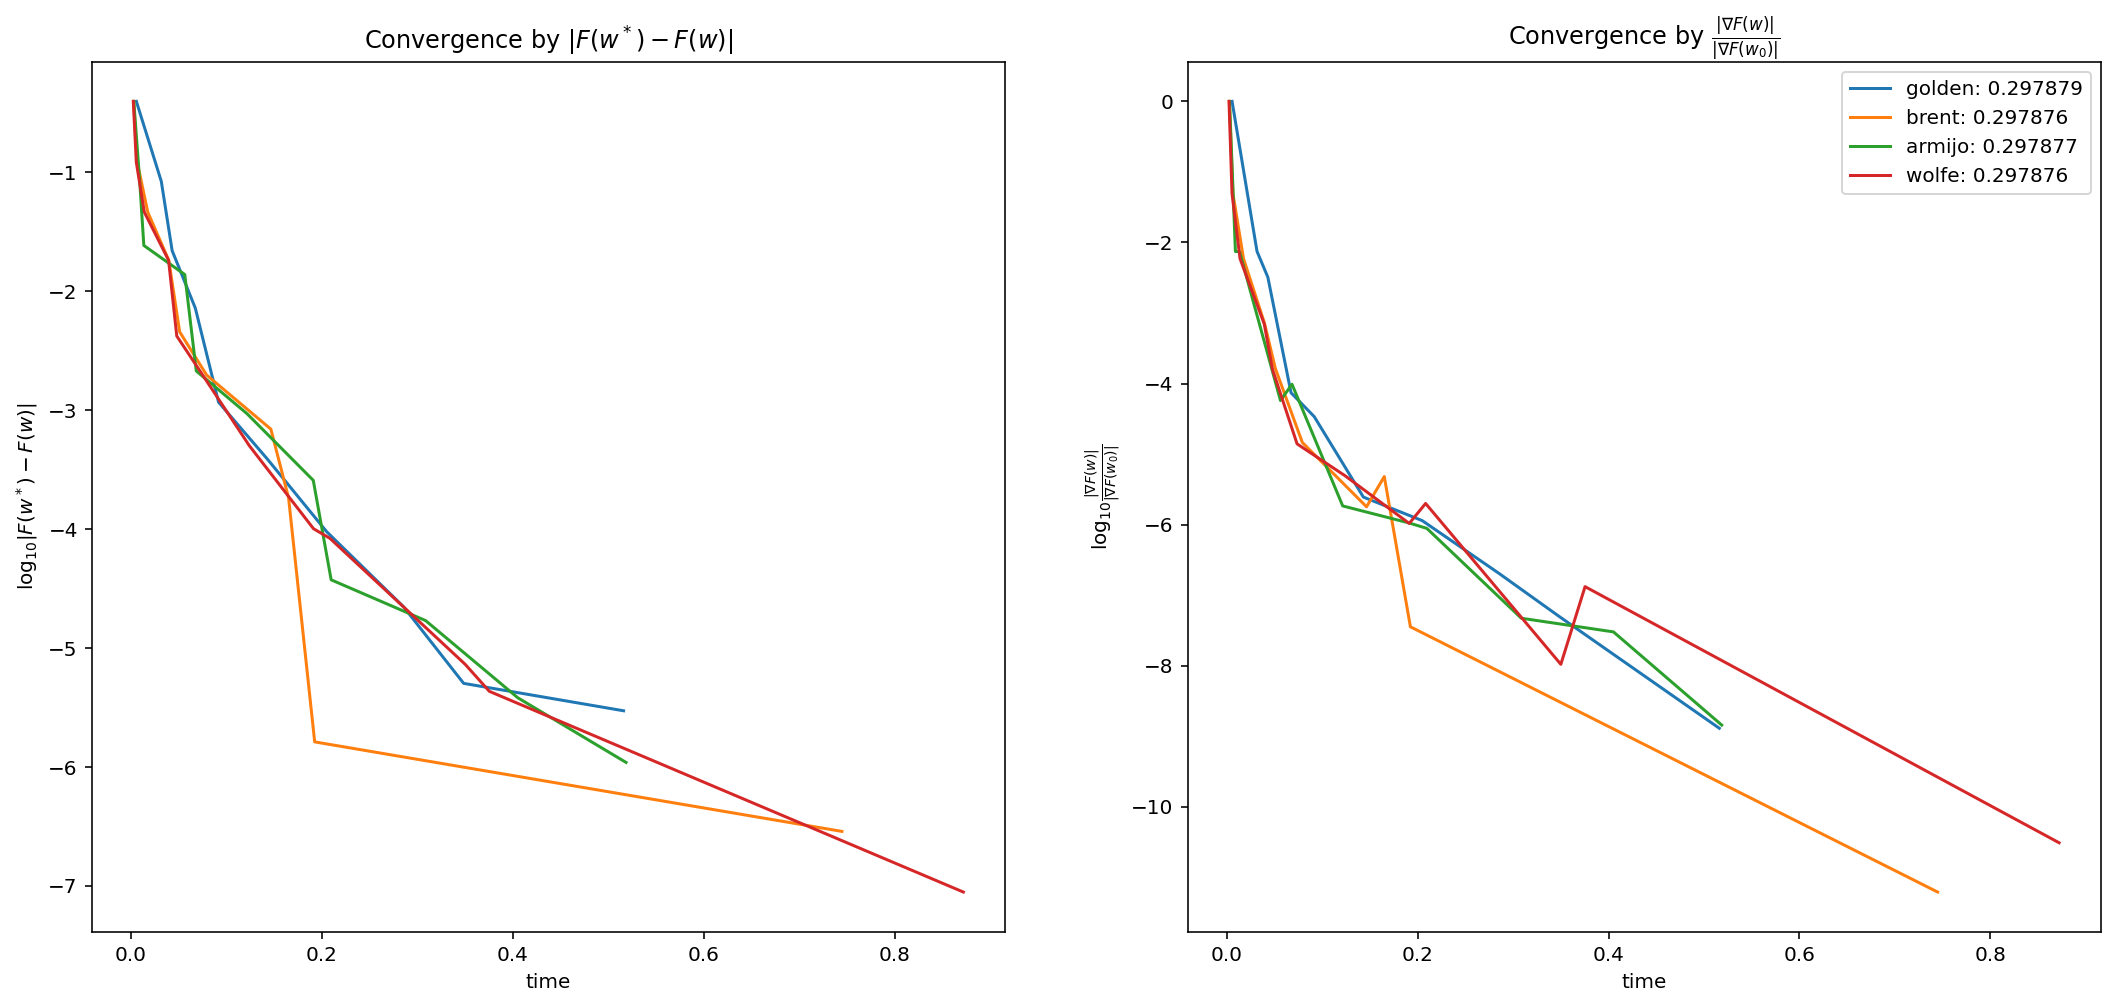

In [15]:
plot_metric(log["a1a"], "hf_newton", "time")

### Conjugate gradient parameters

Можно попробовать разные последовательности для определения точности в методе сопряженных градиентов. На таком количестве итераций сравнение не совсем корректное, однако лучше всего показывает себя $\min(0.1, |\nabla F(w)|) * |\nabla F(w)|$, а константное значение (с линейной сходимостью) худший. В учебнике значение приводится значени с минимумом $0.5$, но для большей стабильности можно ее уменьшить. По моим опытам это улучшает стабильность метода (т.к. требует большей точности от решения).

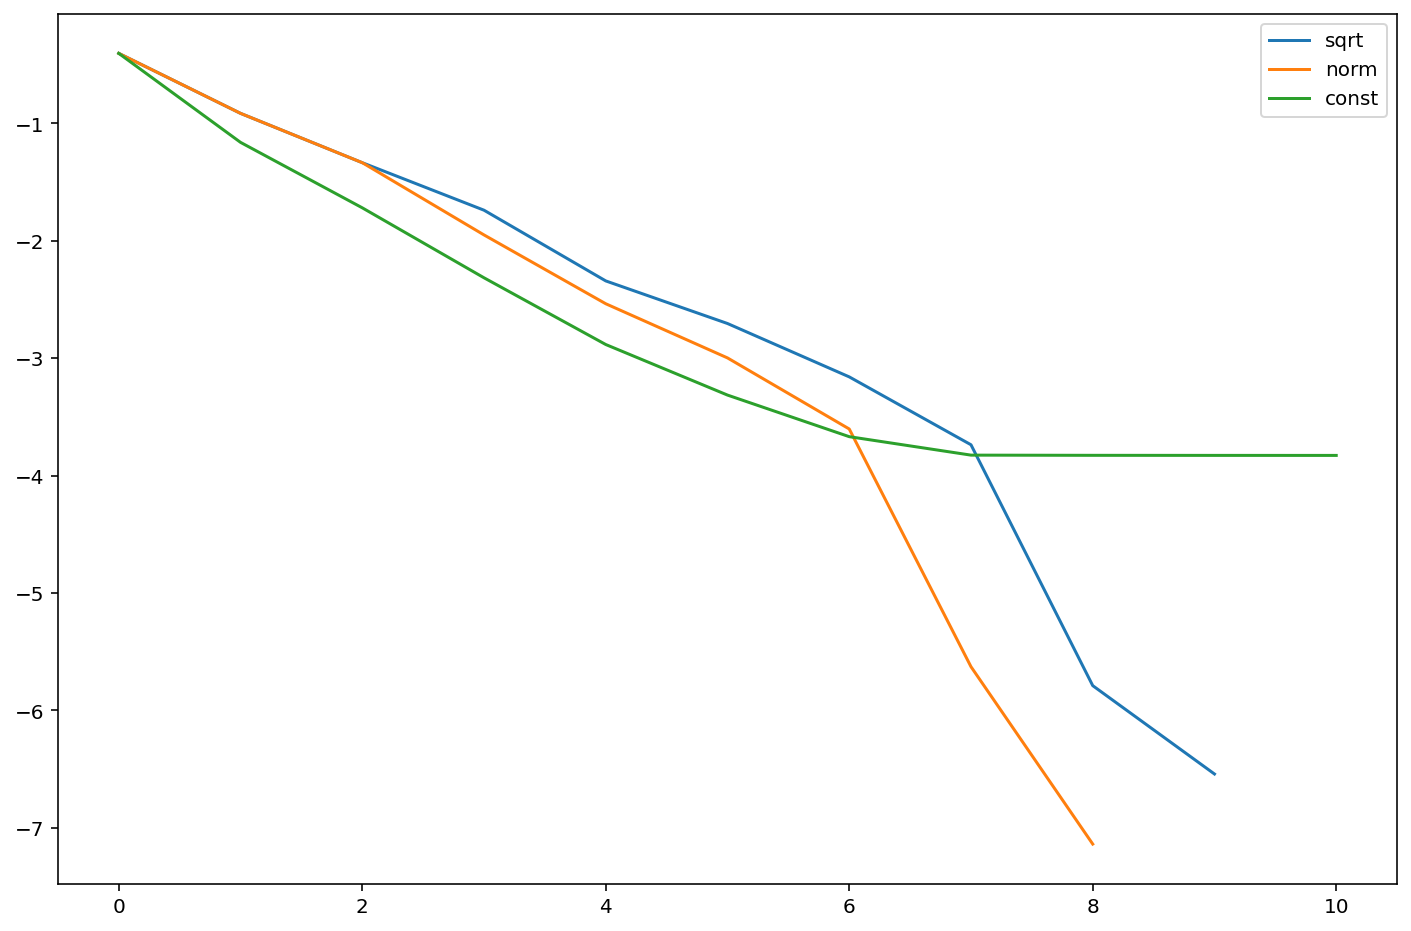

In [33]:
plt.figure(figsize=(12, 8))
for tol in ["sqrt", "norm", "const"]:
    hfn_log = run_optimizer("data/a1a.txt", optimize_hfn, line_search_method="brent", cg_tol=tol)
    info = hfn_log.get_log()
    
    plt.plot(np.arange(info["num_iter"]), 
             np.log10(np.abs(info["entropy"]) - 0.2978755986559931), label=f"{tol}")
plt.legend();

# Breast-cancer dataset

<table>
    <tr>
    <th style="text-align:center"> Gradient Descent </th>
    <th style="text-align:center"> Newton </th>
    <th style="text-align:center"> Hessian-Free Newton </th>
    </tr>
<tr><td>

| line search   |   entropy |   num iter |   oracle calls |   time, s |
|---------------|-----------|------------|----------------|-----------|
| golden        | 0.0754572 |        324 |           8091 |      0.8  |
| brent         | 0.0754646 |        149 |           6835 |      0.69 |
| armijo        | 0.0754031 |        904 |           8136 |      0.99 |
| wolfe         | 0.075468  |        273 |           3171 |      0.45 |
| lipschitz     | 0.0754543 |        363 |           1806 |      0.24 |

</td><td>
    
| line search   |   entropy |   num iter |   oracle calls |   time, s |
|---------------|-----------|------------|----------------|-----------|
| golden        | 0.0753191 |          5 |            121 |      0.03 |
| brent         | 0.0753187 |          8 |             57 |      0.03 |
| armijo        | 0.0753243 |          5 |             38 |      0.01 |
| wolfe         | 0.0753187 |          8 |             33 |      0.02 |
    
</td><td>
    
| line search   |   entropy |   num iter |   oracle calls |   time, s |
|---------------|-----------|------------|----------------|-----------|
| golden        | 0.0753187 |          6 |            310 |      0.05 |
| brent         | 0.0753192 |          8 |            210 |      0.03 |
| armijo        | 0.0753188 |          7 |            238 |      0.03 |
| wolfe         | 0.0753223 |         10 |            349 |      0.05 |
    
</td></tr> 

</table>

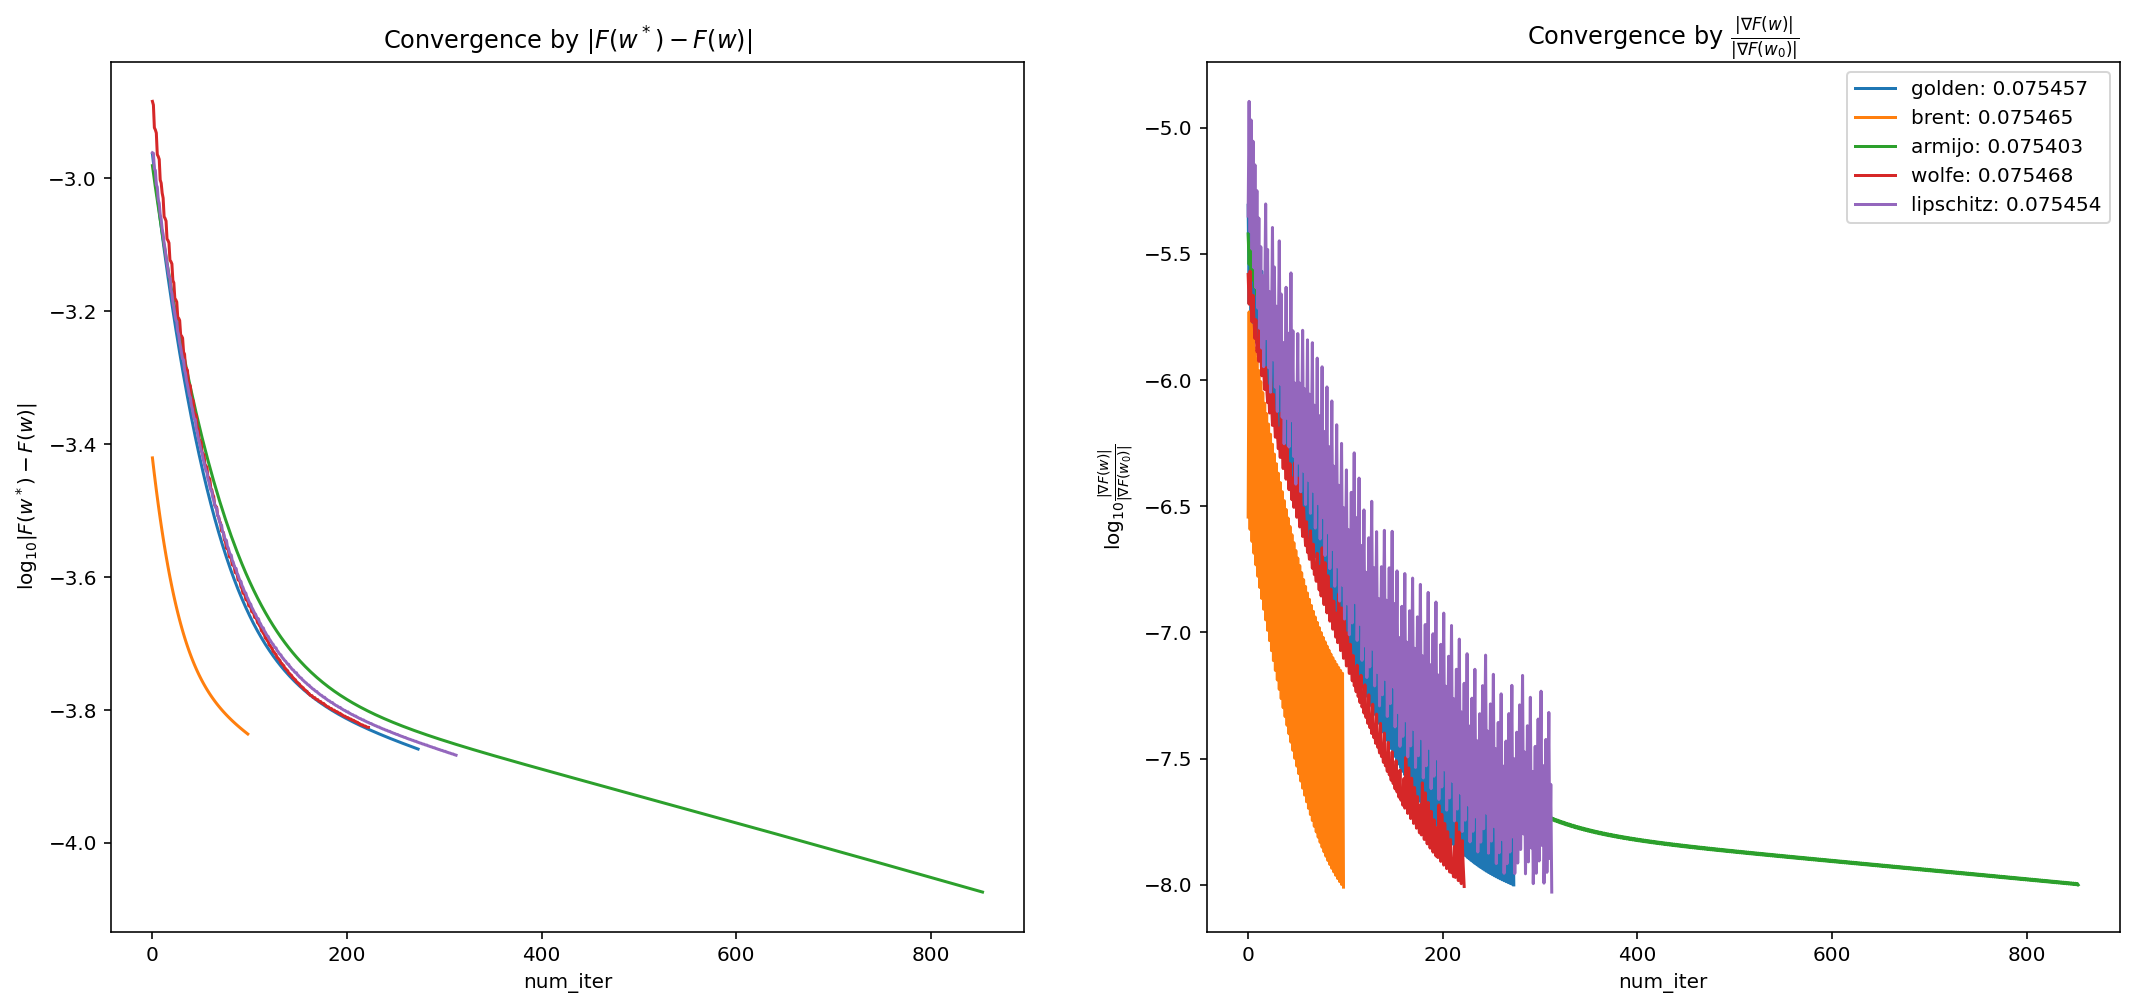

In [16]:
plot_metric(log["breast-cancer_scale"], "gradient descent", "num_iter", offset=50)

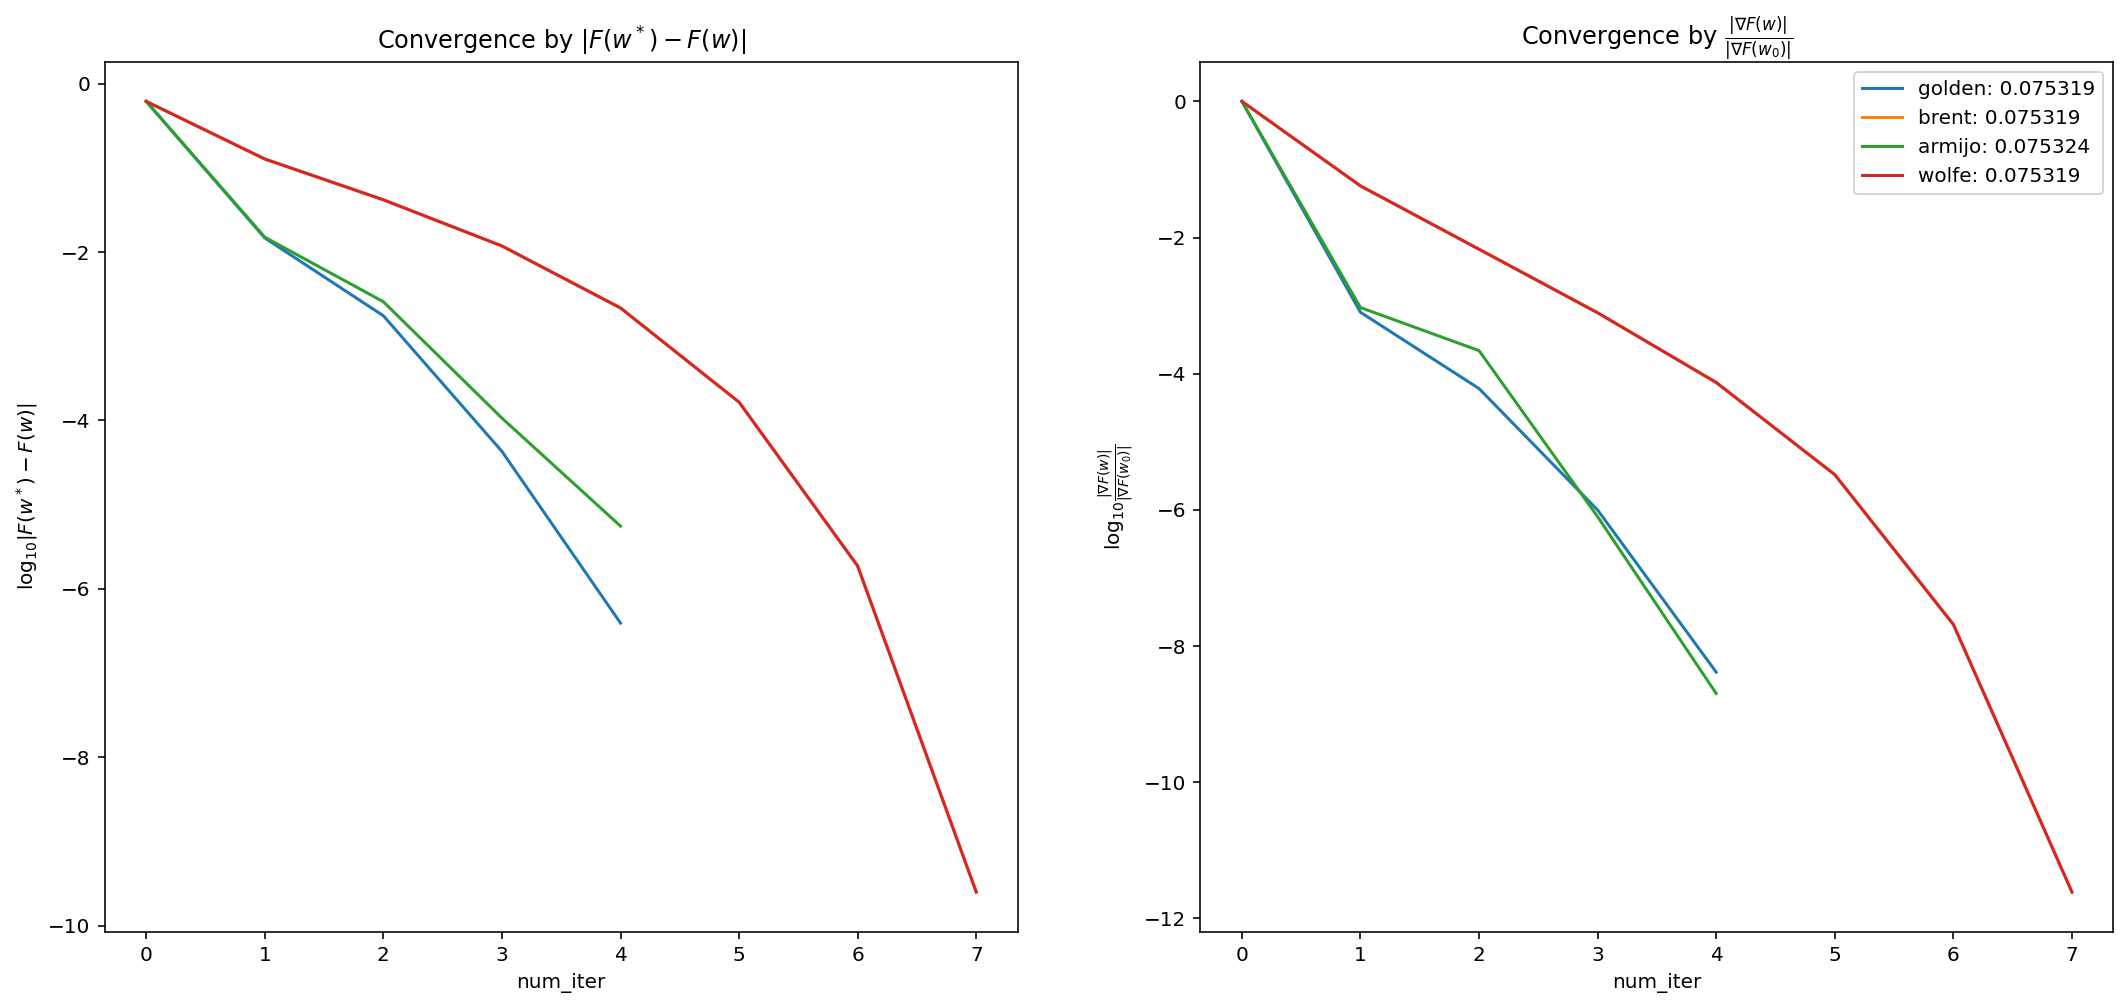

In [17]:
plot_metric(log["breast-cancer_scale"], "newton", "num_iter")

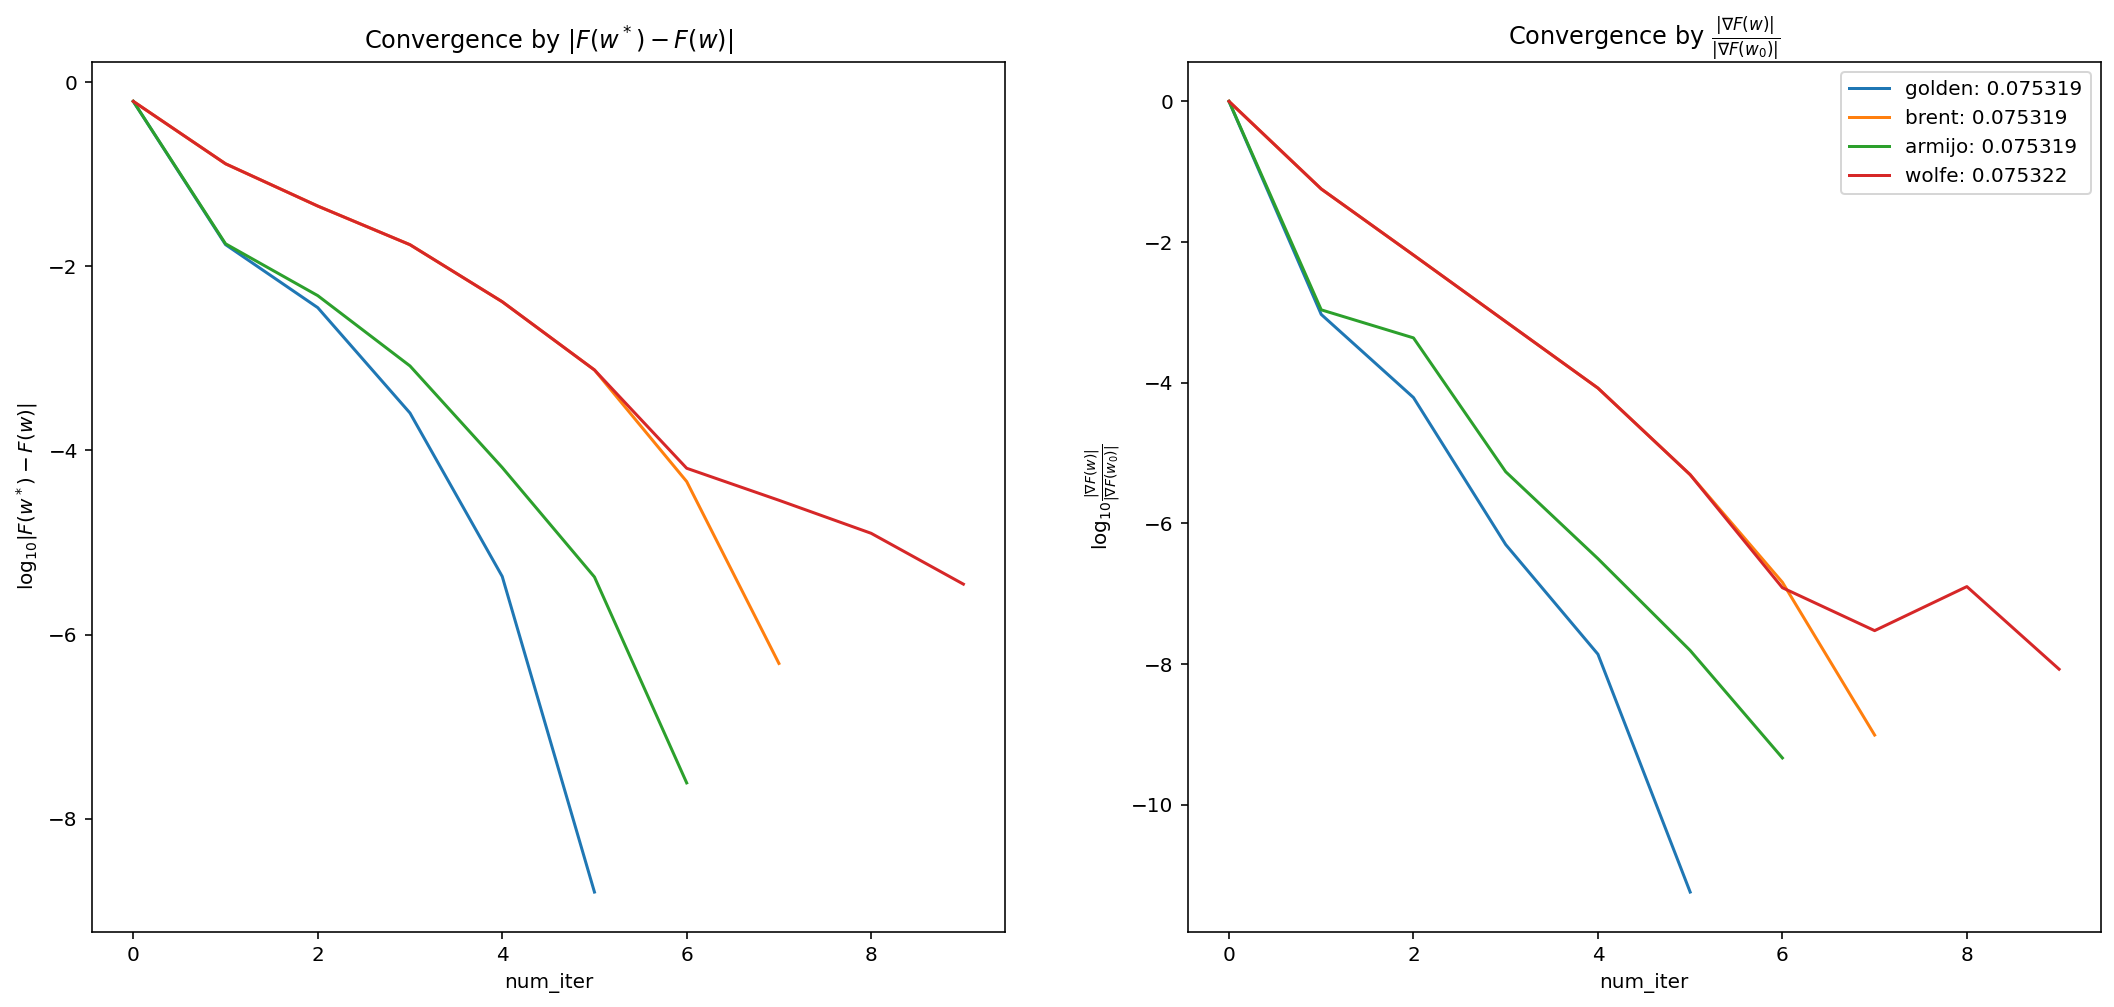

In [18]:
plot_metric(log["breast-cancer_scale"], "hf_newton", "num_iter")

# Synthetic dataset

<table>
    <tr>
    <th style="text-align:center"> Gradient Descent </th>
    <th style="text-align:center"> Newton </th>
    <th style="text-align:center"> Hessian-Free Newton </th>
    </tr>
<tr><td>

| line search   |    entropy |   num iter |   oracle calls |   time, s |
|---------------|------------|------------|----------------|-----------|
| golden        | 0.00211794 |       2585 |          67208 |      5.39 |
| brent         | 0.00239324 |       1473 |          62375 |      5.33 |
| armijo        | 0.00182728 |       2978 |          29230 |      2.35 |
| wolfe         | 0.00251053 |       1704 |          33891 |      2.29 |
| lipschitz     | 0.00218303 |       2354 |          11751 |      1    |

</td><td>
    
| line search   |      entropy |   num iter |   oracle calls |   time, s |
|---------------|--------------|------------|----------------|-----------|
| golden        | -1.00009e-12 |          6 |            158 |      0.01 |
| brent         | -1.00009e-12 |          7 |            194 |      0.02 |
| armijo        | -1.00009e-12 |          6 |             77 |      0.01 |
| wolfe         | -1.00009e-12 |          9 |             85 |      0.01 |
    
</td><td>
    
| line search   |      entropy |   num iter |   oracle calls |   time, s |
|---------------|--------------|------------|----------------|-----------|
| golden        |  6.43325e-05 |          6 |            214 |      0.01 |
| brent         | -1.00009e-12 |          6 |            237 |      0.02 |
| armijo        | -1.00009e-12 |          6 |            116 |      0.02 |
| wolfe         | -1.00009e-12 |          9 |            174 |      0.02 |
    
</td></tr> 

</table>

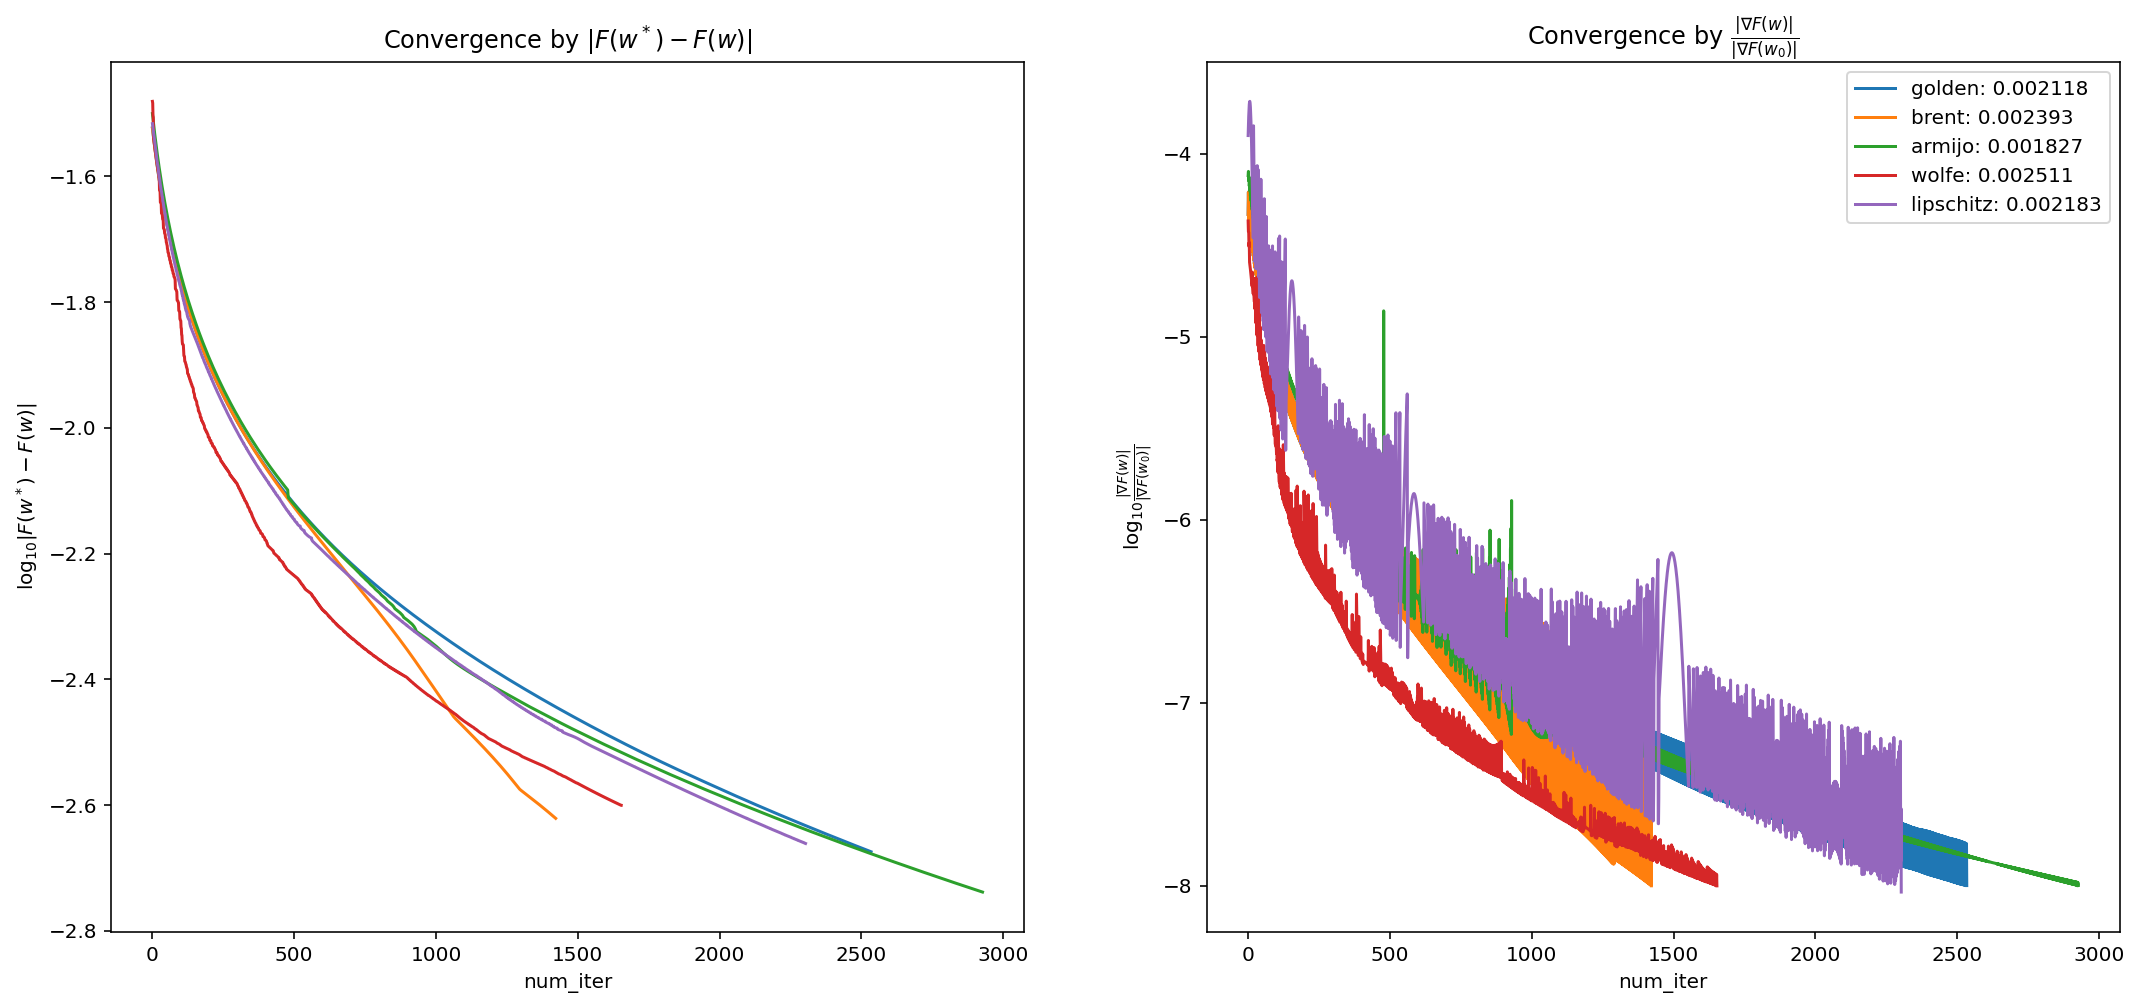

In [19]:
plot_metric(log["generated"], "gradient descent", "num_iter", offset=50)

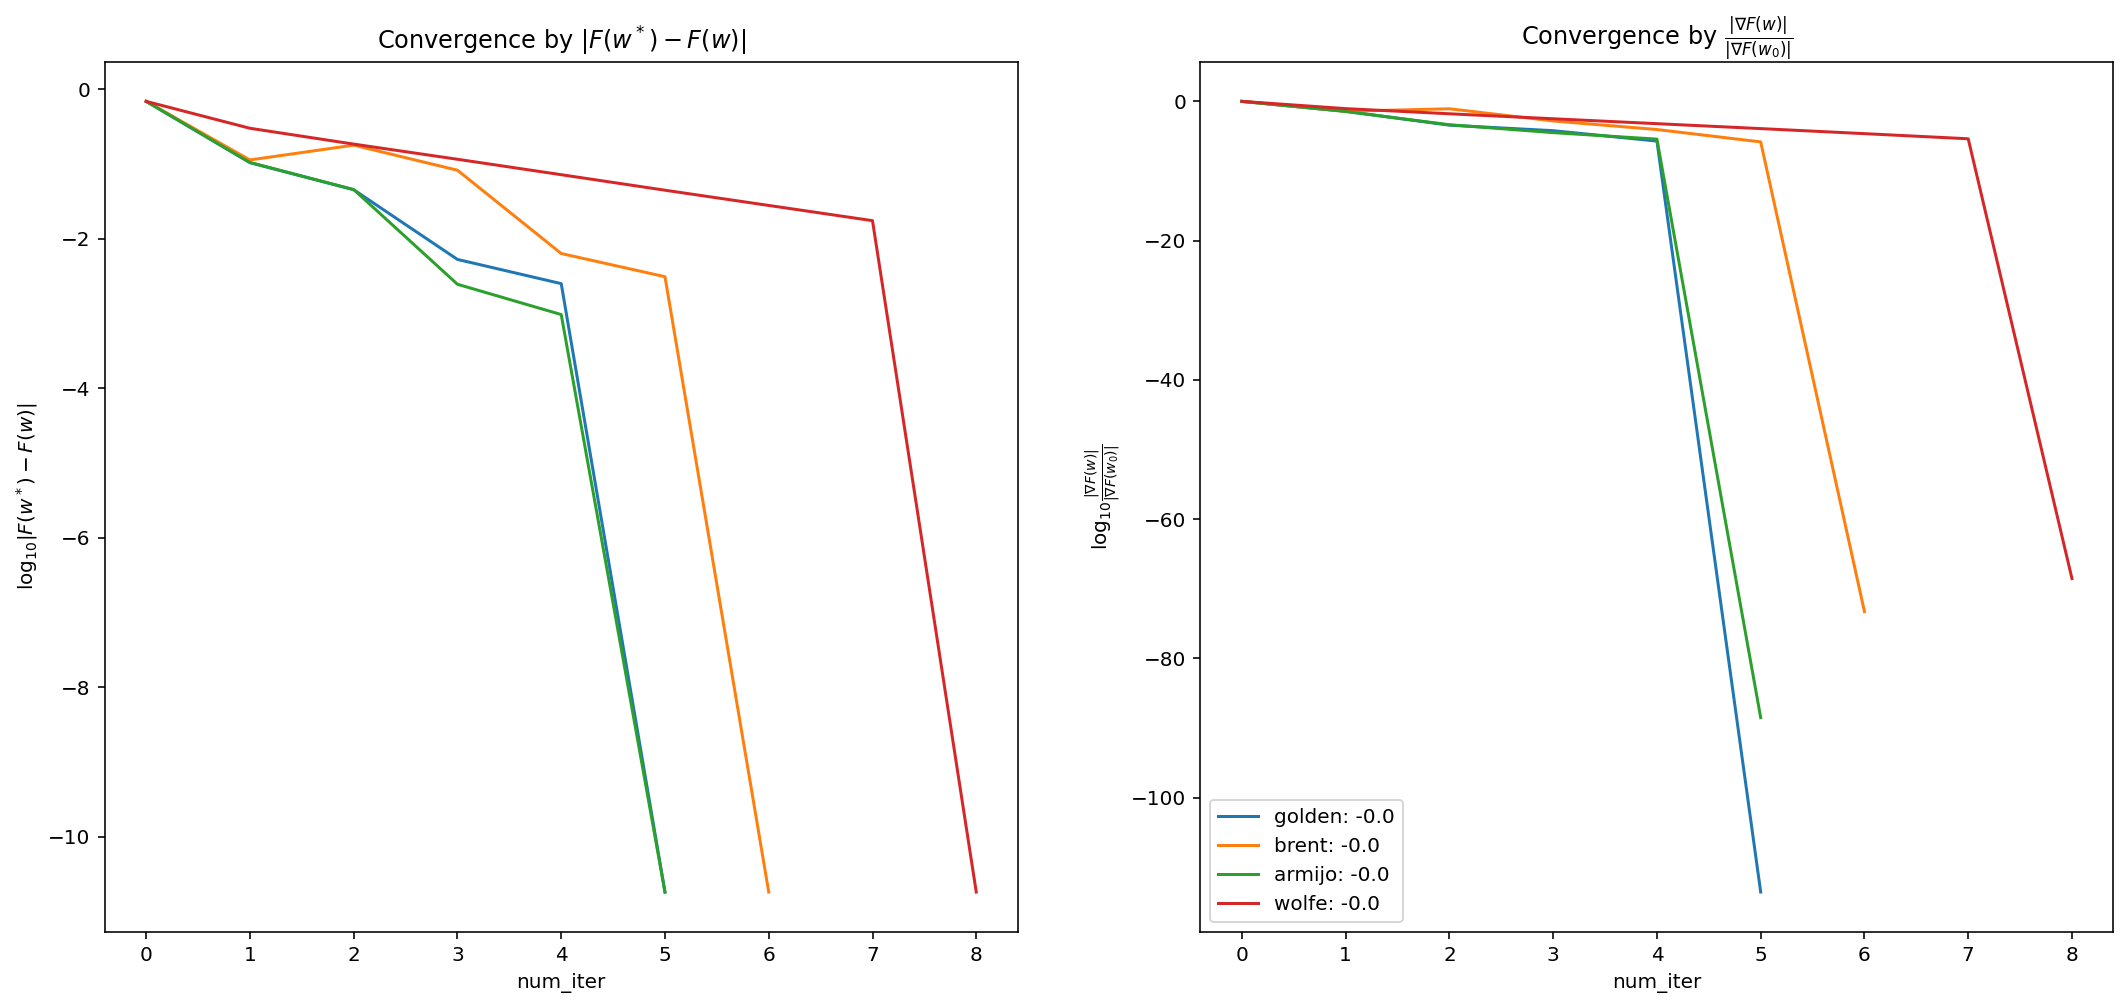

In [20]:
plot_metric(log["generated"], "newton", "num_iter")

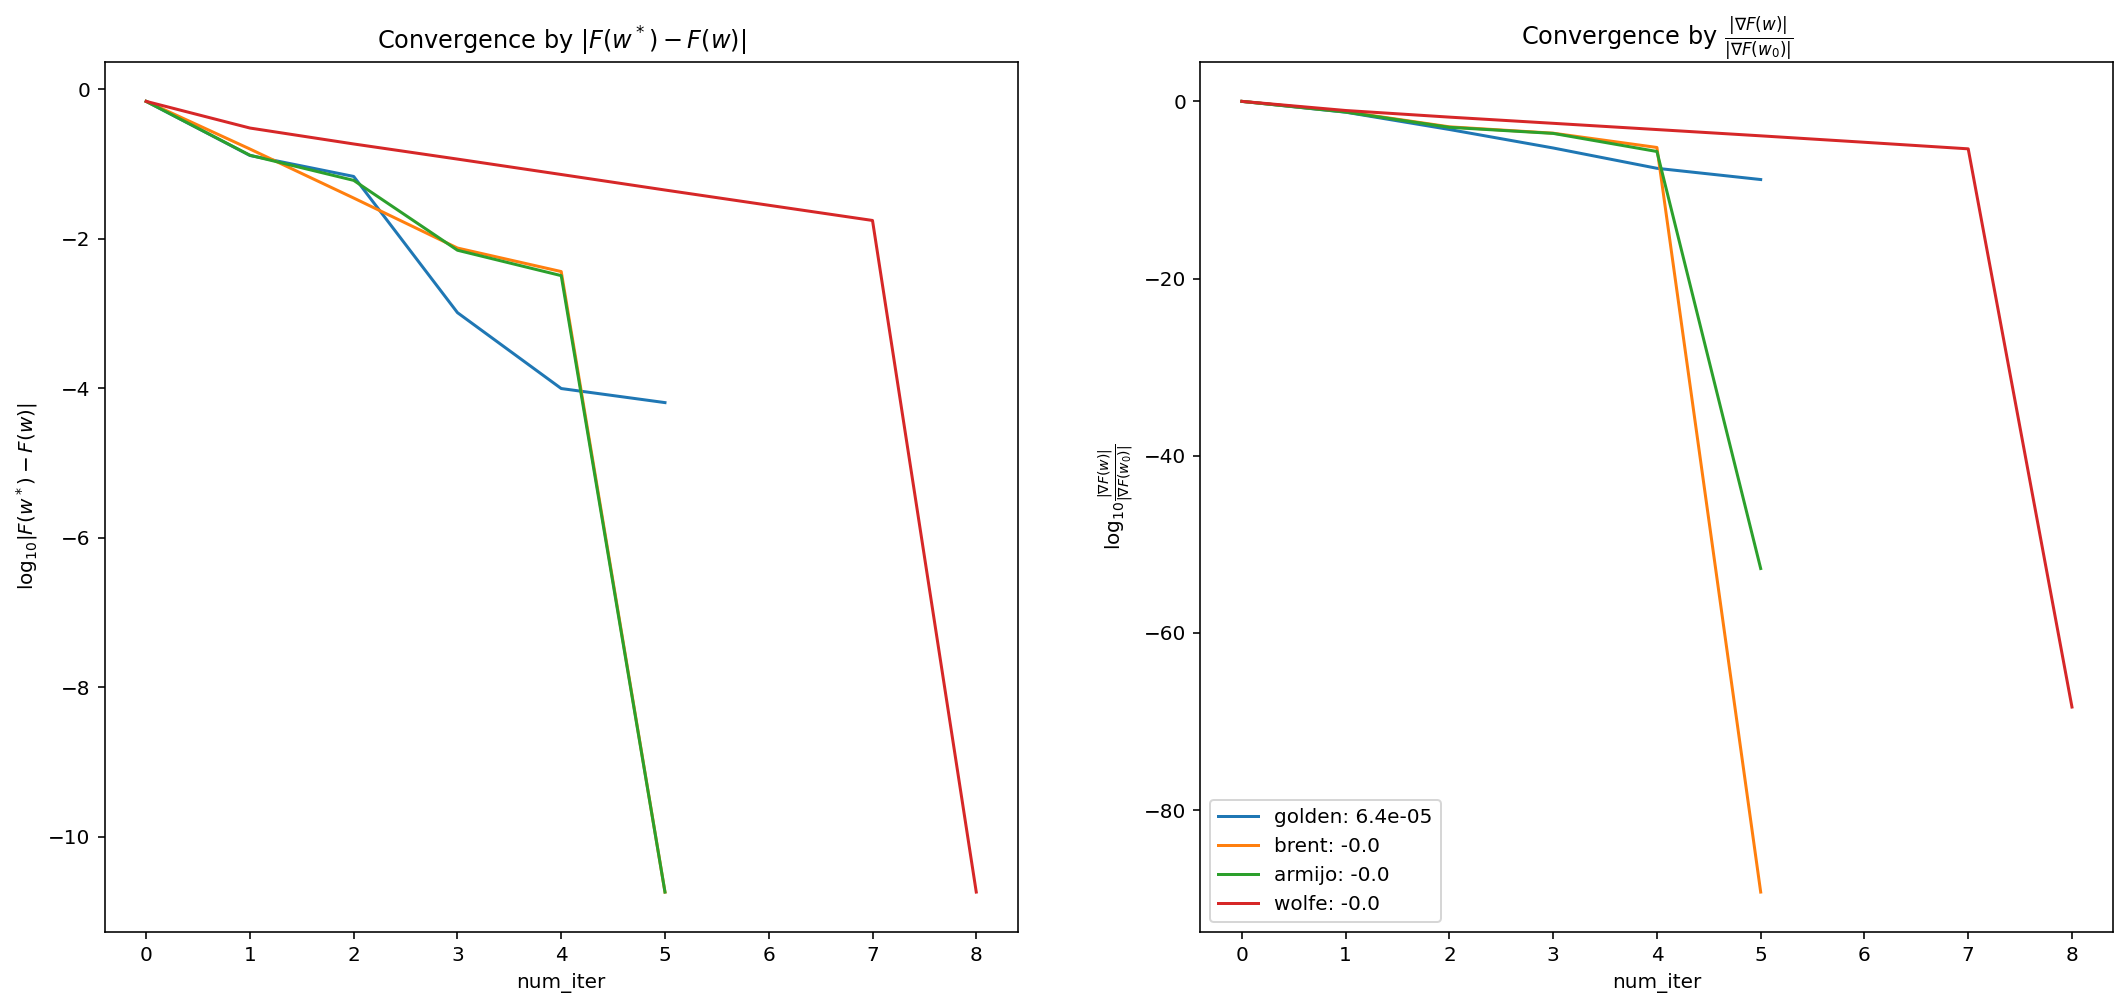

In [21]:
plot_metric(log["generated"], "hf_newton", "num_iter")

# Conclusion